# CombiAnalysis
A repository for all source code and data used in analysis toward the publication described below. This document also contains breif notes, pictures and descriptions. This document is a note taking device and not a publication. 

### Combinatorial analysis of Saccharomyces cerevisiae regulatory elements.
Dhillon, N1., Shelansky, R3., Townshend, B2., Jain, M3., Boeger, H1., Akeson, M3., Endy, D2., Kamakaka, R.T1.

1	Department of MCD Biology, 1156 High Street, University of California, Santa Cruz, CA 95064 USA
E-mail: rohinton@ucsc.edu

2	Department of Bioengineering, Stanford University, Stanford, CA 94305, USA
E-mail: endy@stanford.edu


## Table of Contents
* [Inference of Mean and Standard Deviation OF Expression](#modeling)
    * [Data Input and Manipulation](#input)
    * [Read Statistics](#reads) 
    * [Inference of Cell Proportion from Readcount](#inference)
    * [Analysis of Expression](#expression)
* [Analysis of 9X9 Expression](#9x9)
* [Analysis of Chromatin Structure](#occ)

In [2]:
##MODULES AND PACCKAGES USED FOR VARIOUS COMPUTATION AND VISUALIZATION
import matplotlib
import matplotlib.pyplot as plt ##FOR PLOTTING ;)
from matplotlib_venn import venn2,venn3
         
import scipy.spatial           
import scipy.cluster            
import scipy.linalg            
import scipy.stats
import sklearn.decomposition
import sklearn.impute

import io
import glob
import os.path
import itertools
import pandas                   

## ADJUSTING PLOT SETTINGS mostly for consistant text formats.
%matplotlib inline  

font = {'weight' : 'bold',
        'size'   : 11,
        "family":"Arial"}
plt.rc('font', **font)

<a id='facs'></a>

# Analysis of Total Noise From FACS Data
Plotting the Fano vs log mean for every gene observed by FACs

In [4]:
path    = r'C:\Users\Robert\Desktop\RO\rerequestfordata\data.mat'
data    = scipy.io.loadmat(path)
count   = data['cnt'].transpose([2,0,1])[:,:9,:9]
lgmean  = data['mn'].transpose([2,0,1])[:,:9,:9]
lgstd   = data['st'].transpose([2,0,1])[:,:9,:9]
fano    = data['fano'].transpose([2,0,1])[:,:9,:9]

ENHANCERS = scipy.array(["TDH3","PGK1","PDC1","ACO1","RPL28","TPI1","ICL1","LEU9","ADE2"])
INDEX     = {enhancer:i for enhancer,i in zip(ENHANCERS,range(len(ENHANCERS)))}
PROMOTERS = ENHANCERS

##Exrta data for the CV^2s
# mn1 = pandas.read_csv(r'C:\Users\Robert\Desktop\RO\rerequestfordata\rep1_mean_nolog.csv',header=None).values
# mn2 = pandas.read_csv(r'C:\Users\Robert\Desktop\RO\rerequestfordata\rep2_mean_nolog.csv',header=None).values
# mn3 = pandas.read_csv(r'C:\Users\Robert\Desktop\RO\rerequestfordata\rep3_mean_nolog.csv',header=None).values

# sd1 = pandas.read_csv(r'C:\Users\Robert\Desktop\RO\rerequestfordata\rep1_std_nolog.csv',header=None).values
# sd2 = pandas.read_csv(r'C:\Users\Robert\Desktop\RO\rerequestfordata\rep2_std_nolog.csv',header=None).values
# sd3 = pandas.read_csv(r'C:\Users\Robert\Desktop\RO\rerequestfordata\rep3_std_nolog.csv',header=None).values

# mean = scipy.array([mn1,mn2,mn3])[:,:9,:9]
# std  = scipy.array([sd1,sd2,sd3])[:,:9,:9]
# cv2  = scipy.array([sd**2/mn**2 for mn,sd in zip(mean,std)])
# cfano= scipy.array([sd**2/mn    for mn,sd in zip(mean,std)])

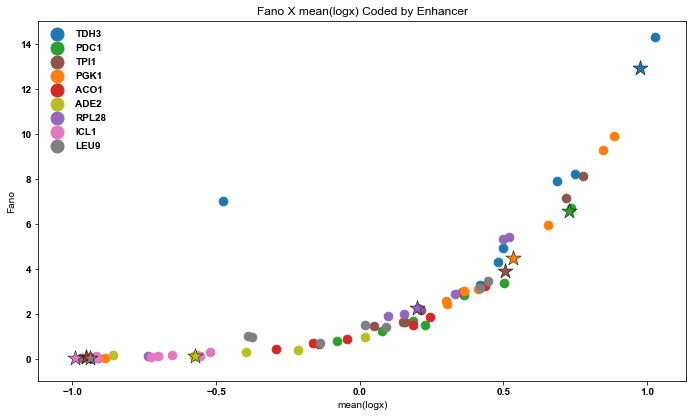

In [5]:
cmap     = plt.get_cmap('tab10')
#cmap     = plt.get_cmap('bwr')
fig      = plt.figure(figsize=(9,5))
main_ax  = fig.add_axes([1,1,1,1])

means    = scipy.mean(lgmean,axis=0)#lgmean[0].T
fanos    = scipy.mean(fano,axis=0)  #fano[0].T
labels   = ENHANCERS
order    = scipy.argsort(-scipy.mean(means,axis=0  ))
means = means [order]
labels= labels[order]
fanos = fanos [order]
colors= [cmap(i) for i in range(len(ENHANCERS))]
#colors=[cmap(i/max(scipy.mean(means,axis=0  ))) for i in scipy.mean(means,axis=0  )]
##Plotting non endoginous
for m,f,enhancer in zip(means,fanos,labels):
    i = INDEX[enhancer]
    c = colors[i]
    selection = scipy.ones_like(m).astype(bool)
    selection[i]=False

    m= scipy.array(m)
    f= scipy.array(f)
    main_ax.scatter(m[selection],f[selection],s=75,label=enhancer,c = c  )
#plotting endoginous
for m,f,enhancer in zip(means,fanos,labels):
    i = INDEX[enhancer]
    c = colors[i]
    main_ax.scatter(m[i],f[i],marker='*',s=250,c=c,edgecolors ='black',linewidths=0.5)
    
main_ax.set_title ("Fano X mean(logx) Coded by Enhancer")
main_ax.set_xlabel("mean(logx)")
main_ax.set_ylabel("Fano")
main_ax.legend(markerscale=1.5,fancybox=True,edgecolor='white')#shadow =True
#fig.savefig(folder +"\\"+'EnhancerFanoXMeanlgx_bwr.svg', bbox_inches="tight")



<a id='modeling'></a>

## INFERENCE OF MEAN AND STANDARD DEVIATION OF EXPRESSION
#### FITTING PROCEDURE AS DESCRIBED IN “High-Throughput Cellular RNA Device Engineering.”

Townshend, Brent, Andrew B. Kennedy, Joy S. Xiang, and Christina D. Smolke. 2015. “High-Throughput Cellular RNA Device Engineering.” Nature Methods 12 (10): 989–94.

We determined the mean and variance of expression for a regulatory fragment by fitting an estimate of that fragment’s prevalence in each fraction to a log-normal model of protein expression, as described in 2015 townsend et al. The estimate, $ x_{i,b} $, of the ratio of cells containing fragment, i, sorted into each fraction, b, was determined by normalizing the number of reads, $r_{i,b} $ by multiplication with $ \frac{C_b}{R_b ∑ C_b } $, where $ C_b $ and  $ R_b $ are the total number of cells sorted and reads mapped from bin b, respectively. (First, calculating the fractional representation of fragment, i, in bin b and subsequently scaling that fraction by the fraction of cells observed in bin b by FACS). We then assume that $ x_{i,b}$  are random variables sampled from binned log-normal distributions where the bins are determined by the FACS fraction boundaries.

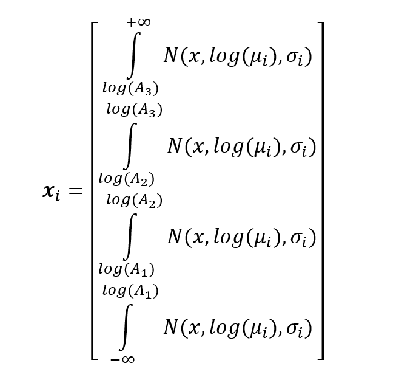


Where, $ {x}_i $, is the vector of ratios for all bins described above,$ \mu_i $, is the mean expression, $\sigma_i $, is the standard deviation of expression, $ A_b $, is the expression value for the upper boundary of bin b by FACS. 

In [11]:

##EQUATIONS FOR BIN PROBABILITIES
# bin1 = lambda A1   , mew, sigma: scipy.stats.norm.cdf(scipy.log(A1), scipy.log(mew), sigma) 
# bin2 = lambda A1,A2, mew, sigma: scipy.stats.norm.cdf(scipy.log(A2), scipy.log(mew), sigma) - scipy.stats.norm.cdf(scipy.log(A1), scipy.log(mew), sigma)
# bin3 = lambda A2,A3, mew, sigma: scipy.stats.norm.cdf(scipy.log(A3), scipy.log(mew), sigma) - scipy.stats.norm.cdf(scipy.log(A2), scipy.log(mew), sigma)
# bin4 = lambda A3   , mew, sigma: 1 - scipy.stats.norm.cdf(scipy.log(A3), scipy.log(mew), sigma) 

class Bounds(object):
    """Helper for basin hopping bounds.
    """
    def __init__(self,xmax=[500],xmin=[1]):
        self.xmax = scipy.array(xmax)
        self.xmin = scipy.array(xmin)
        
    def __call__(self, **kwargs):
        x= kwargs['x_new']
        tmax = bool(scipy.all(x<self.xmax))
        tmin = bool(scipy.all(x>self.xmin))
        return tmax and tmin

class LogNormalFromBins:
    """Helper class for doing Log Normal Fit in above analysis
    """
    def __init__(self, sigma = 0.95, A1=30, A2=100, A3=250, mewmin=1, mewmax=500, sigmamin=0.1, sigmamax=3):
        """
        Establishes parametization for model of expected bin counts.
        """
        self.A1, self.A2, self.A3 = A1,A2,A3
        self.sigma                = sigma
        self.mewmin,self.mewmax,self.sigmamin,self.sigmamax = mewmin,mewmax,sigmamin,sigmamax
        
    def calculateExpectedBinCounts(self, mew, sigma):
        """
        Vector of expected bin counts described above.
        """
        vectorized = scipy.array([
            scipy.stats.norm.cdf(scipy.log(self.A1), scipy.log(mew), sigma),
            scipy.stats.norm.cdf(scipy.log(self.A2), scipy.log(mew), sigma) - scipy.stats.norm.cdf(scipy.log(self.A1), scipy.log(mew), sigma),
            scipy.stats.norm.cdf(scipy.log(self.A3), scipy.log(mew), sigma) - scipy.stats.norm.cdf(scipy.log(self.A2), scipy.log(mew), sigma),
            1 - scipy.stats.norm.cdf(scipy.log(self.A3), scipy.log(mew), sigma) 
        ]).T
        if vectorized.ndim ==1:
            return(vectorized[scipy.newaxis])
        return(vectorized)
    
    def leastSquare(self, mew, sigma, gene):
        """
        leastSquare of cakcukatedExpectedBinCounts verse observed gene.
        """
        ls = scipy.sum((self.calculateExpectedBinCounts(mew, sigma) - gene) ** 2, axis=1)
        #Only works for vectorized....
        ls[mew > self.mewmax]     = scipy.inf
        ls[mew < self.mewmin]     = scipy.inf
        ls[sigma > self.sigmamax] = scipy.inf
        ls[sigma < self.sigmamin] = scipy.inf
        return (ls)
    
    def fit2d(self, gene):
        """Brute force fit of mean and std using leastSquare.
        """ 
        objfunc = lambda X: self.leastSquare(X[0],X[1],gene)
        fit = scipy.optimize.brute(objfunc, ranges = [slice(self.mewmin,self.mewmax,20),slice(self.sigmamin,self.sigmamax,0.5)])
        return(fit)
    
    def fit1d(self, gene):
        """basinhpping fit of mean.
        """ 
        minimizer_kwargs = dict(method="L-BFGS-B", bounds=[[self.mewmin,self.mewmax]])
        objfunc = lambda X: self.leastSquare(X,self.sigma,gene)
        fit=scipy.optimize.basinhopping(objfunc , x0=[50], accept_test=Bounds(),niter=25,stepsize=100,minimizer_kwargs=minimizer_kwargs)
        return(fit.x[0])
    
model  = LogNormalFromBins()
model.fit1d([0.8,0.2,0,0]), model.fit2d([0.8,0.2,0,0])

(13.81148999552363, array([23.06997682,  0.31209506]))

<a id='input'></a>

## DATA MANIPULATION

Pre Computation of pairwise mean estimates.
And assorted usefull gene sets.

In [102]:
##Names and Defined Clusters
__GENEINDEX__         = [scipy.nan,"ACO1","ACT1","ADE2","ADH1","ADH2","ALD6","CDC19","CUP1","GLK1","HIS3","HXT2","ICL1","LEU9","OLE1","PDC1","PGI1","PGK1","PSP2","PYC2","RPL28","TAL1","TDH3","TEF1","TPI1","GAL1","PHO5"]
__TBP__               = ['TDH3','PDC1','ADH1','OLE1','PGK1','PGI1','ACT1','ACO1','GLK1','HXT2','ICL1','PHO5']
__5ATAC__             = ['TAL1','PHO5','LEU9','PSP2','HXT2','GLK1','ADE2','ALD6','ACO1','ACT1','PGK1','OLE1','RPL28','TPI1','CDC19','TEF1','PDC1']
__3ATAC__             = ['GAL1','ADH2','ICL1','HIS3','PGI1']
__IV__                = 'I_V'
__SUMNORMALIZED__     = 'SumNormalized'
__MAXNORMALIZED__     = 'MaxNormalized'
__EXPERIMENT__        = 'Experiment'
__REPLICATE__         = 'Replicate'
__CONDITION__         = 'Condition'
__ENHANCER__          = 'Enhancer'
__PRIME5__            = 'Prime5'
__PRIME3__            = 'Prime3'
__PROMOTER__          = 'Promoter'
__PROMOTERNORMALIZED__= 'PromoterZscore'
__ENHANCERNORMALIZED__= 'EnhancerZscore'
bin_averages          = scipy.array([1,60,120,250])

In [13]:
#READING IN DATA AND COUNTING READS PER FRAGMENT TYPE ['UAS','CORE','UTR5','UTR3']
##showing the order 1..26. The mapping is described by the _GENEINDEX_ name e.g. 1->ACO1
##For example, the line of presort.csv
##16,22,21,4
##Indicates a read with UAS: 16 (PGI1), CORE:22 (TDH3), UTR5: 21 (TAL1), UTR3: 4 (ADH1)
presort = pandas.read_csv(r'C:\Users\Robert\Desktop\RO\presort.csv')
NB01    = pandas.read_csv(r'C:\Users\Robert\Desktop\RO\NB01.csv')
NB02    = pandas.read_csv(r'C:\Users\Robert\Desktop\RO\NB02.csv')
NB03    = pandas.read_csv(r'C:\Users\Robert\Desktop\RO\NB03.csv')
NB04    = pandas.read_csv(r'C:\Users\Robert\Desktop\RO\NB04.csv')

In [14]:
##COUNTING
NB01f    =NB01    .groupby(['UAS','CORE','UTR5','UTR3']).size()
NB02f    =NB02    .groupby(['UAS','CORE','UTR5','UTR3']).size()
NB03f    =NB03    .groupby(['UAS','CORE','UTR5','UTR3']).size()
NB04f    =NB04    .groupby(['UAS','CORE','UTR5','UTR3']).size()
presortf = presort.groupby(['UAS','CORE','UTR5','UTR3']).size()


In [15]:
##BUILDING THE DATA FRAME
seqdata         = pandas.DataFrame(list(itertools.product(range(0,27),repeat=4 ))) ##CONSTRUCT ALL POSSIBLE GENE FRAGMENTS
seqdata.columns = ['UAS','CORE','UTR5','UTR3']
seqdata         = seqdata.set_index(['UAS','CORE','UTR5','UTR3'])
##JOIN ALL DATA SETS TOGETHER INTO ONE DATA FRAME
seqdata         = seqdata.join(pandas.DataFrame(presortf),rsuffix='0').join(pandas.DataFrame(NB01f),rsuffix='1').join(pandas.DataFrame(NB02f),rsuffix='2').join(pandas.DataFrame(NB03f),rsuffix='3').join(pandas.DataFrame(NB04f),rsuffix='4')
seqdata         = seqdata.reset_index()
seqdata.columns = ['Enhancer','Promoter','Prime5','Prime3','presort','NB01','NB02','NB03','NB04']
del NB01f; del presortf; del NB02f; del NB03f; del NB04f


In [16]:
##REPLACE INDECES WITH ACTUAL GENE NAMES
seqdata.Enhancer = [__GENEINDEX__[x] for x in seqdata.Enhancer]
seqdata.Promoter = [__GENEINDEX__[x] for x in seqdata.Promoter]
seqdata.Prime5   = [__GENEINDEX__[x] for x in seqdata.Prime5]
seqdata.Prime3   = [__GENEINDEX__[x] for x in seqdata.Prime3]
seqdata['Total'] = seqdata[['NB01','NB02','NB03','NB04']].fillna(0).sum(axis=1)

In [17]:
## DEFINING SETS OF FEATURES
## READS WHICH CONTAIN NO MISSING FEATURES
allfeatures   = ~pandas.isnull(seqdata.Enhancer) & ~pandas.isnull(seqdata.Promoter) & ~pandas.isnull(seqdata.Prime5) & ~pandas.isnull(seqdata.Prime3)
## READS WHICH CONTAIN NO MISSING PRIME FEATURES
primefeatures = ~pandas.isnull(seqdata.Prime5)   & ~pandas.isnull(seqdata.Prime3)
## READS WHICH CONTAIN NO MISSING CORE or UAS FEATURES
corefeatures  = ~pandas.isnull(seqdata.Enhancer) & ~pandas.isnull(seqdata.Promoter)
## READS WHICH CONTAIN NO LABELED FEATURES WHATSOEVER
nofeatures    =  pandas.isnull(seqdata.Enhancer) & pandas.isnull(seqdata.Promoter) & pandas.isnull(seqdata.Prime5) & pandas.isnull(seqdata.Prime3)
## IN PRACTICE THE NEGATION OF THIS IS DESIRED. READS WHICH CONTAIN AT LEAST 1 DEFINED FEATURE
features      = ~nofeatures

In [18]:
##THIS is a really silly way to do this: But it is simple. 
##This can be slow [for my slow computer a couple hours...] due to the slowness of fitting procedure.
##Everygene fragment must be fit to the model twice. For each pair of elements.
##I suggest a precompute and reading in of data. I guess I should have written it that way...Sorry.

def buildGroupedDataFrame(group):
    """
    Constructs a data frame containing analysis for a individual pair of regulatory elements
    """
    model = LogNormalFromBins()
    Cb             = scipy.array([15663845,6462912,1886385,527069])  
    df             = seqdata[allfeatures].groupby(group)['NB01','NB02','NB03','NB04'].sum()
    Rb             = df.sum().values
    Cib            = df.apply(lambda x: x*Cb/Rb/sum(x*Cb/Rb),axis=1).values
    ##Depricated analysis
    ########################################################
    bin_averages   = scipy.array([1,60,120,250])
    df['Score*' ]   = scipy.sum(df.apply(lambda x: x/sum(x),axis=1).values * bin_averages,axis=1)/250
    df['NormedScore*']   = scipy.sum(bin_averages *(Cib.T /scipy.sum(Cib,axis=1)).T,axis=1)      /250
    ########################################################
    ##Total counts
    df['Evidence'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)
    ##Fitting
    fit2d          = scipy.array([model.fit2d(gene) for gene in Cib])
    df['mean2d']   = fit2d[:,0]
    df['std2d']    = fit2d[:,1]
    df['mean1d']   = scipy.array([model.fit1d(gene) for gene in Cib])
    return(df)



## Actually doing the analysis, and transposition of data frames
dfEP = buildGroupedDataFrame([__ENHANCER__, __PROMOTER__])
dfE5 = buildGroupedDataFrame([__ENHANCER__, __PRIME5__  ])
dfE3 = buildGroupedDataFrame([__ENHANCER__, __PRIME3__  ])
dfPE = dfEP.swaplevel() #dfPE = buildGroupedDataFrame([__PROMOTER__, __ENHANCER__])
dfP5 = buildGroupedDataFrame([__PROMOTER__, __PRIME5__  ])
dfP3 = buildGroupedDataFrame([__PROMOTER__, __PRIME3__  ])
df5E = dfE5.swaplevel()#df5E = buildGroupedDataFrame([__PRIME5__  , __ENHANCER__])
df5P = dfP5.swaplevel()#df5P = buildGroupedDataFrame([__PRIME5__  , __PROMOTER__])
df53 = buildGroupedDataFrame([__PRIME5__  , __PRIME3__  ])
df3E = dfE3.swaplevel()#df3E = buildGroupedDataFrame([__PRIME3__  , __ENHANCER__])
df3P = dfP3.swaplevel()#df3P = buildGroupedDataFrame([__PRIME3__  , __PROMOTER__])
df35 = df53.swaplevel()#df35 = buildGroupedDataFrame([__PRIME3__  , __PRIME5__  ])


##A dictionary of pair wise data sets keys by the grouping
__DATA__  = {(__ENHANCER__, __PROMOTER__):dfEP,
             (__ENHANCER__, __PRIME5__  ):dfE5,
             (__ENHANCER__, __PRIME3__  ):dfE3,
             (__PROMOTER__, __ENHANCER__):dfPE,
             (__PROMOTER__, __PRIME5__  ):dfP5,
             (__PROMOTER__, __PRIME3__  ):dfP3,
             (__PRIME5__  , __ENHANCER__):df5E,
             (__PRIME5__  , __PROMOTER__):df5P,
             (__PRIME5__  , __PRIME3__  ):df53,
             (__PRIME3__  , __ENHANCER__):df3E,
             (__PRIME3__  , __PROMOTER__):df3P,
             (__PRIME3__  , __PRIME5__  ):df35}

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:571: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[0]:
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:582: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[-2]:
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:587: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[-1]:
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:601: RuntimeWarning: invalid value encountered in less
  if fxcc < fsim[-1]:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:87

<a id='reads'></a>

## Read Statistics

#### LEGEND
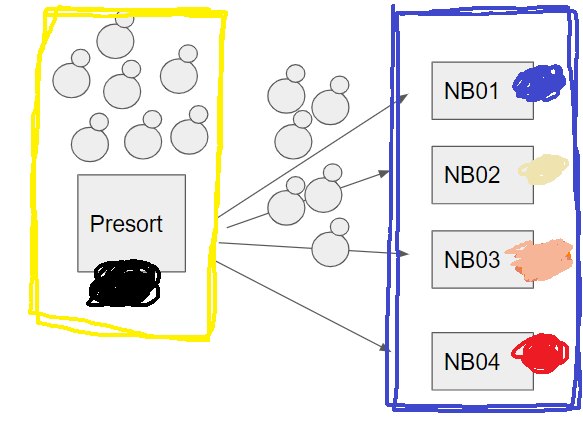

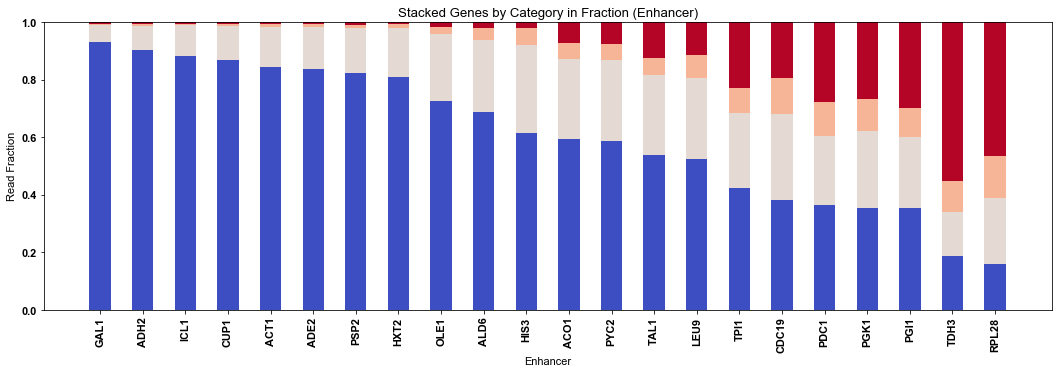

In [94]:
##READ FRACTION HISTOGRAMS
def HistByCategory(mat):
    fig      = plt.figure(figsize=(14,4))
    main_ax  = fig.add_axes([1,1,1,1])
    order = scipy.argsort(-mat.NB01)
    ##JUST 2 CATEGORIES
    x     = scipy.arange (len(mat))
    main_ax.bar(x-0.175 , mat.NB01[order],width=0.3,color='darkblue'   ,align='center')
    x     = scipy.arange (len(mat))
    main_ax.bar(x+0.175 , mat.NB04[order],width=0.3,color='darkred'   ,align='center')
    ##ALLFOUR
    # x     = scipy.arange (len(mat))
    # main_ax.bar(x-0.3 , mat.NB01[order],width=0.2,color='darkblue'   ,align='center')
    # x     = scipy.arange (len(mat))
    # main_ax.bar(x-0.1 , mat.NB02[order],width=0.2,color='lightblue'   ,align='center')
    # x     = scipy.arange (len(mat))
    # main_ax.bar(x+0.1 , mat.NB03[order],width=0.2,color='mistyrose'   ,align='center')
    # x     = scipy.arange (len(mat))
    # main_ax.bar(x+0.3 , mat.NB04[order],width=0.2,color='red'   ,align='center')
    ticks    = main_ax.xaxis.set_ticks(range(len(mat)))
    labels   = main_ax.xaxis.set_ticklabels(mat.index[order],rotation=90)
    labels   = main_ax.set_xlabel(mat.index.name)
    title    = main_ax.set_title('Genes by Category in Fraction ({})'.format(mat.index.name))
    labels   = main_ax.set_ylabel('Read Fraction')
    figure = plt.gcf()
    return(figure)

def StackedHist(mat):
    fig      = plt.figure(figsize=(14,4))
    main_ax  = fig.add_axes([1,1,1,1])
    order = scipy.argsort(-mat.NB01)
    x     = scipy.arange (len(mat))
    ##STACKED ALL
    cmap = shiftedColorMap(plt.get_cmap('coolwarm'),0.004,0.2,1,name='shiftedcmap')
    main_ax.bar(x, mat.NB01[order], width=0.5                                                              ,color=cmap(0)    ,align='center')
    main_ax.bar(x, mat.NB02[order], width=0.5, bottom=  mat.NB01[order]                                    ,color=cmap(0.24) ,align='center')
    main_ax.bar(x, mat.NB03[order], width=0.5, bottom=  mat.NB01[order] + mat.NB02[order]                  ,color=cmap(0.48) ,align='center')
    main_ax.bar(x, mat.NB04[order], width=0.5, bottom=  mat.NB01[order] + mat.NB02[order] + mat.NB03[order],color=cmap(0.99) ,align='center')
    ticks    = main_ax.xaxis.set_ticks(range(len(mat)))
    labels   = main_ax.xaxis.set_ticklabels(mat.index[order],rotation=90)
    labels   = main_ax.set_xlabel(mat.index.name)
    title    = main_ax.set_title('Stacked Genes by Category in Fraction ({})'.format(mat.index.name))
    labels   = main_ax.set_ylabel('Read Fraction')
    main_ax.set_ylim([0,1])
    figure = plt.gcf()
    return(figure)

##LOOKING AT LEVELS OF EXPRESSION BY NORMALIZING WITH THE ROW AVERAGES
df              = seqdata[allfeatures].groupby([__ENHANCER__])['NB01','NB02','NB03','NB04'].sum()
mat             = df[['NB01','NB02','NB03','NB04']].apply(lambda x: x/sum(x),axis=1)
mat['Evidence'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)
mat             = mat[mat.Evidence > 100]
figure = StackedHist(mat)

# figure.savefig(folder+'StackedHistEnhancer.svg', bbox_inches="tight")


# df              = seqdata[allfeatures].groupby([__PROMOTER__])['NB01','NB02','NB03','NB04'].sum()
# mat             = df[['NB01','NB02','NB03','NB04']].apply(lambda x: x/sum(x),axis=1)
# mat['Evidence'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)
# mat             = mat[mat.Evidence > 100]
# #figure = HistByCategory(mat)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# figure = StackedHist(mat)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure.savefig(folder+'StackedHistPromoter.svg', bbox_inches="tight")


# df              = seqdata[allfeatures].groupby([__PRIME5__])['NB01','NB02','NB03','NB04'].sum()
# mat             = df[['NB01','NB02','NB03','NB04']].apply(lambda x: x/sum(x),axis=1)
# mat['Evidence'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)
# mat             = mat[mat.Evidence > 100]
# #figure = HistByCategory(mat)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# figure = StackedHist(mat)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure.savefig(folder+'StackedHistPrime5.svg', bbox_inches="tight")


# df              = seqdata[allfeatures].groupby([__PRIME3__])['NB01','NB02','NB03','NB04'].sum()
# mat             = df[['NB01','NB02','NB03','NB04']].apply(lambda x: x/sum(x),axis=1)
# mat['Evidence'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)
# mat             = mat[mat.Evidence > 100]
# #figure = HistByCategory(mat)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# figure = StackedHist(mat)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure.savefig(folder+'StackedHistPrime3.svg', bbox_inches="tight")


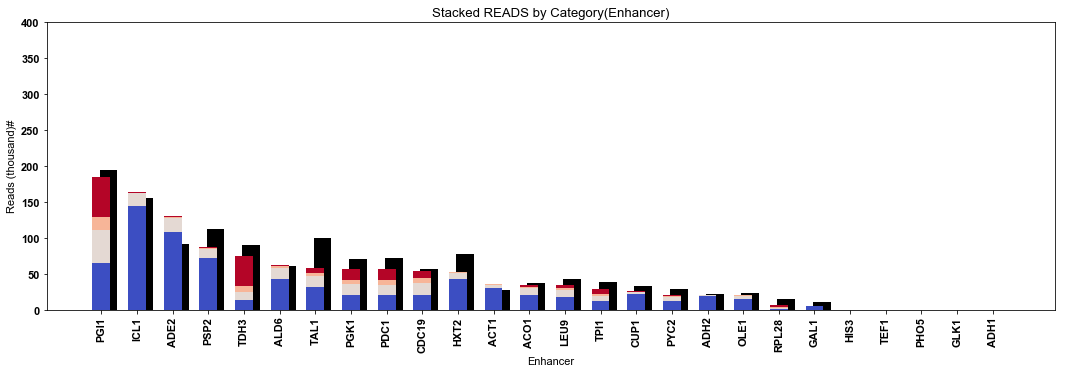

In [95]:
##Read Fractions but comparing both Sorted and Presorted samples
def StackedReadHistogram(mat):
    fig      = plt.figure(figsize=(14,4))
    main_ax  = fig.add_axes([1,1,1,1])
    order  = scipy.argsort(-mat.Total.values)
    #order = scipy.argsort((mat.NB01/mat[['NB01','NB02','NB03','NB04']].sum(axis=1)).fillna(1).values)
    x     = scipy.arange (len(mat))
    ##STACKED ALL
    cmap = shiftedColorMap(plt.get_cmap('coolwarm'),0.004,0.2,1,name='shiftedcmap')
    
    main_ax.bar(x+0.2, mat.presort[order]/1000, width=0.5                                                              ,color='black'    ,align='center')
    main_ax.bar(x    , mat.NB01[order   ]/1000, width=0.5                                                              ,color=cmap(0)    ,align='center')
    main_ax.bar(x    , mat.NB02[order   ]/1000, width=0.5, bottom=  mat.NB01[order]/1000                                    ,color=cmap(0.24) ,align='center')
    main_ax.bar(x    , mat.NB03[order   ]/1000, width=0.5, bottom=  mat.NB01[order]/1000 + mat.NB02[order]/1000                  ,color=cmap(0.48) ,align='center')
    main_ax.bar(x    , mat.NB04[order   ]/1000, width=0.5, bottom=  mat.NB01[order]/1000 + mat.NB02[order]/1000 + mat.NB03[order]/1000,color=cmap(0.99) ,align='center')

#     main_ax.bar(x+0.2, mat.presort[order], width=0.5                                                              ,color='black'    ,align='center')
#     main_ax.bar(x    , mat.NB01[order   ], width=0.5                                                              ,color=cmap(0)    ,align='center')
#     main_ax.bar(x    , mat.NB02[order   ], width=0.5, bottom=  mat.NB01[order]                                    ,color=cmap(0.24) ,align='center')
#     main_ax.bar(x    , mat.NB03[order   ], width=0.5, bottom=  mat.NB01[order] + mat.NB02[order]                  ,color=cmap(0.48) ,align='center')
#     main_ax.bar(x    , mat.NB04[order   ], width=0.5, bottom=  mat.NB01[order] + mat.NB02[order] + mat.NB03[order],color=cmap(0.99) ,align='center')

    
    ticks    = main_ax.xaxis.set_ticks(range(len(mat)))
    labels   = main_ax.xaxis.set_ticklabels(mat.index[order],rotation=90)
    labels   = main_ax.set_xlabel(mat.Element.unique()[0])
    title    = main_ax.set_title('Stacked READS by Category({})'.format(mat.Element.unique()[0]))
    labels   = main_ax.set_ylabel('Reads (thousand)#')
    main_ax.set_ylim([0,400])
    figure = plt.gcf()
    return(figure)

def ReadHistogram(mat):
    fig      = plt.figure(figsize=(14,4))
    main_ax  = fig.add_axes([1,1,1,1])
    order = scipy.argsort(-mat.Total)
    cmap = shiftedColorMap(plt.get_cmap('coolwarm'),0.004,0.2,1,name='shiftedcmap')
    main_ax.bar(range(len(mat)), mat.Total[order]/1000, width=0.5  ,color='black'    ,align='center')
    ticks    = main_ax.xaxis.set_ticks(range(len(mat)))
    labels   = main_ax.xaxis.set_ticklabels(mat.index[order],rotation=90)
    labels   = main_ax.set_xlabel(mat.Element.unique()[0])
    labels   = main_ax.set_ylabel("Reads (Thousdands)")
    title    = main_ax.set_title("Reads Containing {}".format(mat.Element.unique()[0]))
    figure = plt.gcf()
    return(figure)

ogdf = seqdata[~nofeatures].groupby([__ENHANCER__,__PROMOTER__,__PRIME5__,__PRIME3__])['presort','NB01','NB02','NB03','NB04'].sum().reset_index()
df          = pandas.melt(ogdf,value_vars=[__ENHANCER__,__PROMOTER__,__PRIME5__,__PRIME3__],id_vars =['presort','NB01','NB02','NB03','NB04'],var_name='Element',value_name='Gene')
df          = df.groupby(['Gene','Element'])[['presort','NB01','NB02','NB03','NB04']].sum()
df['Total'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)

mat = df.loc[pandas.IndexSlice[:,'Enhancer'],:].reset_index('Element')

figure = StackedReadHistogram(mat)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure.savefig(folder+'AdvancedReadsStackedHistEnhancer.svg', bbox_inches="tight")

# figure = ReadHistogram(mat)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure.savefig(folder+'ReadsStackedHistEnhancer.svg', bbox_inches="tight")


# mat = df.loc[pandas.IndexSlice[:,'Promoter'],:].reset_index('Element')
# figure = StackedReadHistogram(mat)
# figure.savefig(folder+'AdvancedReadsStackedHistPromoter.svg', bbox_inches="tight")
# figure = ReadHistogram(mat)
# figure.savefig(folder+'ReadsStackedHistPromoter.svg', bbox_inches="tight")

# mat = df.loc[pandas.IndexSlice[:,'Prime5'],:].reset_index('Element')
# figure = StackedReadHistogram(mat)
# figure.savefig(folder+'AdvancedReadsStackedHistPrime5.svg', bbox_inches="tight")
# figure = ReadHistogram(mat)
# figure.savefig(folder+'ReadsStackedHistPrime5.svg', bbox_inches="tight")

# mat = df.loc[pandas.IndexSlice[:,'Prime3'],:].reset_index('Element')
# figure = StackedReadHistogram(mat)
# figure.savefig(folder+'AdvancedReadsStackedHistPrime3.svg', bbox_inches="tight")
# figure = ReadHistogram(mat)
# figure.savefig(folder+'ReadsStackedHistPrime3.svg', bbox_inches="tight")


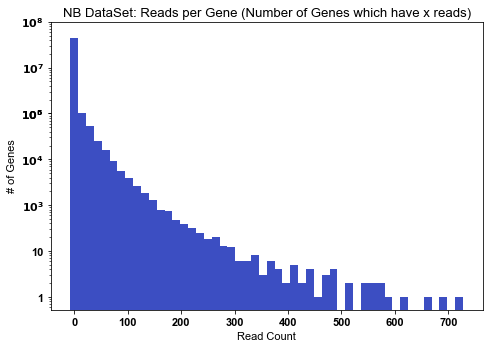

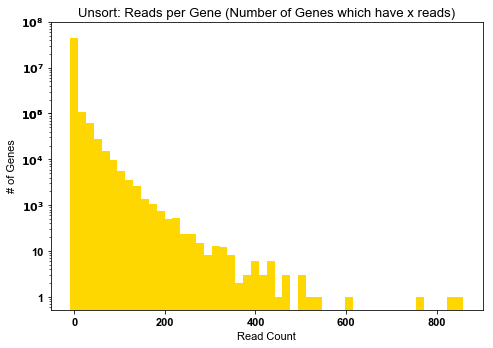

In [96]:
##Number of gene fragments by Number of reads in support of each fragment
def GeneReadHistogram(data, title , color):
    ##Read count distribution across genes
    fig      = plt.figure(figsize=(6,4))
    main_ax  = fig.add_axes([1,1,1,1])
    hist = main_ax.hist(data, bins = 50, color = color,align='left')
    plt.yscale('log')
    main_ax.set_xlabel('Read Count')
    main_ax.set_ylabel('# of Genes')
    main_ax.set_title('{}: Reads per Gene (Number of Genes which have x reads)'.format(title))
    ticks    = main_ax.yaxis.set_ticks([1,10,100,1000,10000,10000,100000,1000000])
    ticks    = main_ax.yaxis.set_ticklabels([1,10,r'$10^3$',r'$10^4$',r'$10^5$',r'$10^6$',r'$10^7$',r'$10^8$'])
    figure = plt.gcf()
    return(figure)

cmap = shiftedColorMap(plt.get_cmap('coolwarm'),0.004,0.2,1,name='shiftedcmap')

box = GeneReadHistogram(seqdata[allfeatures].Total            ,'NB DataSet',cmap(0))
box.savefig(folder+'GeneReadHistTotal.svg', bbox_inches="tight")


box = GeneReadHistogram(seqdata[allfeatures].presort.fillna(0),'Unsort','gold')
box.savefig(folder+'GeneReadHistUnsort.svg', bbox_inches="tight")


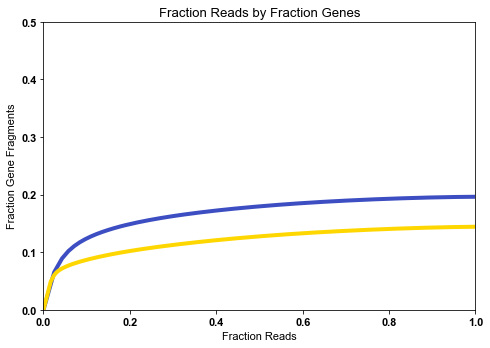

In [97]:
def FractionReadsByFractionGenes(nb,unsort):
    data  = nb
    n     = len (data)
    total = sorted(data)
    y     = scipy.cumsum(scipy.trim_zeros(total))/sum(data)
    x     = scipy.arange(len(y))/n
    data  = unsort 
    n     = len (data)
    total = sorted(data)
    yy     = scipy.cumsum(scipy.trim_zeros(total))/sum(data)
    xx     = scipy.arange(len(yy))/n
    fig      = plt.figure(figsize=(6,4))
    main_ax  = fig.add_axes([1,1,1,1])
    cmap = shiftedColorMap(plt.get_cmap('coolwarm'),0.004,0.2,1,name='shiftedcmap')
    plt1 = main_ax.plot(y,x, color = cmap(0),lw=4)
    plt2 = main_ax.plot(yy,xx, color = 'gold',lw=4)
    main_ax.set_xlim([0,1])
    main_ax.set_ylim([0,0.5])
    main_ax
    main_ax.set_xlabel('Fraction Reads')
    main_ax.set_ylabel('Fraction Gene Fragments')
    main_ax.set_title('Fraction Reads by Fraction Genes')
    figure = plt.gcf()
    return (figure)

figure = FractionReadsByFractionGenes(seqdata[allfeatures].Total,seqdata[allfeatures].presort.fillna(0))
figure.savefig(folder+'FractionGenesByReads.svg', bbox_inches="tight")


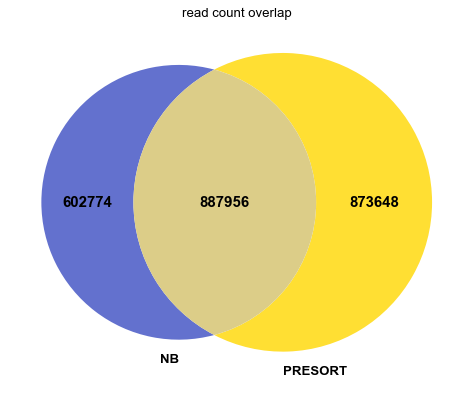

In [98]:
##LAST CONTROLE FOR SURE BECAUSE I AM WASTING TIME ON THIS I THINK Overlap between Presort and NB and the overlap between NBs

def ReadCountVenn(matrix,title='title'):
    matrix = matrix.fillna(0)
    matrix['left']  =  scipy.clip(matrix.Total   - matrix.presort ,0,None)
    matrix['right'] =  scipy.clip(matrix.presort - matrix.Total ,0,None)
    matrix['middle']   =  scipy.amin([matrix.presort , matrix.Total],axis=0)
    matrix = matrix[['NB01','NB02','NB03','NB04','Total','presort','left','middle','right']]
    matrix = matrix[(matrix.T != 0).any()]

    from matplotlib_venn import venn2,venn3
    fig      = plt.figure(figsize=(8,5))
    main_ax  = fig.add_axes([1,1,1,1])
    cmap = shiftedColorMap(plt.get_cmap('coolwarm'),0.004,0.2,1,name='shiftedcmap')
    v = venn2(ax = main_ax, subsets = {'10':int(matrix.left.sum()), '11':int(matrix.middle.sum()) , '01':int(matrix.right.sum())}, set_labels = ('NB', 'PRESORT'),set_colors=(cmap(0),'gold'))
    v.get_patch_by_id('10').set_alpha(0.8)
    v.get_patch_by_id('11').set_alpha(1)
    v.get_patch_by_id('01').set_alpha(0.8)
    #main_ax.get_children()[3].set_color('white')
    texts = [x for x in main_ax.get_children() if (type(x)==matplotlib.text.Text and str.isdigit(x.get_text()))]
    [text.set_fontsize(15) for text in texts]
    main_ax.set_title(title)
    figure = plt.gcf()
    return(figure)

matrix          =  seqdata[~nofeatures]
figure          = ReadCountVenn(matrix,'read count overlap')
#pdf.savefig(figure, bbox_inches="tight",dpi=300) 
figure.savefig(folder+'VennNBUnsortReads.svg', bbox_inches="tight")


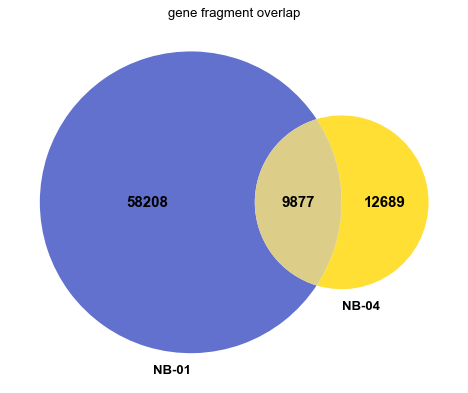

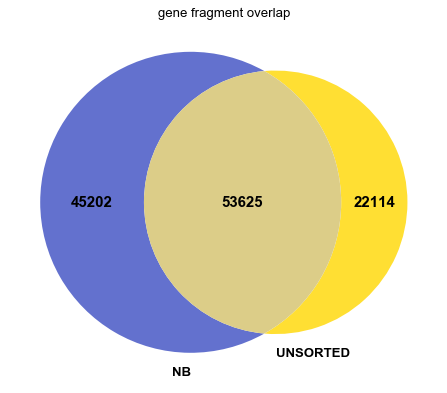

In [99]:
def PresenceAbsenceVenn(group1, group2,set_labels = ('NB', 'UNSORTED'),title=''):
    nb1    = group1 > 0
    nb4    = group2 > 0
    l,m,r  = sum(nb1 & ~nb4), sum(nb1 & nb4),sum( ~nb1  &  nb4)
    a      = sum(nb1 | nb4)
    
    fig      = plt.figure(figsize=(8,5))
    main_ax  = fig.add_axes([1,1,1,1])
    ##PRESENCE ABSENCE PLOTS for NB vs Presort 
    cmap   = shiftedColorMap(plt.get_cmap('coolwarm'),0.004,0.2,1,name='shiftedcmap')
    v      = venn2(ax = main_ax, subsets = {'10':int(l), '11':int(m) , '01':int(r)}, set_labels=set_labels ,set_colors=(cmap(0),'gold'))
    v.get_patch_by_id('10').set_alpha(0.8)
    v.get_patch_by_id('11').set_alpha(1)
    v.get_patch_by_id('01').set_alpha(0.8)
    main_ax.set_title(title)
    texts = [x for x in main_ax.get_children() if (type(x)==matplotlib.text.Text and str.isdigit(x.get_text()))]
    [text.set_fontsize(15) for text in texts]
    figure = plt.gcf()
    return(figure)

matrix             =  seqdata[~nofeatures]
matrix             =  matrix.fillna(0)
matrix['left']     =  scipy.clip(matrix.Total   - matrix.presort ,0,None)
matrix['right']    =  scipy.clip(matrix.presort - matrix.Total ,0,None)
matrix['middle']   =  scipy.amin([matrix.presort , matrix.Total],axis=0)
matrix             =  matrix[['NB01','NB02','NB03','NB04','Total','presort','left','middle','right']]

figure = PresenceAbsenceVenn(matrix.NB01,matrix.NB04, set_labels = ('NB-01', 'NB-04'),title='gene fragment overlap')
figure.savefig(folder+'VennNB1NB4_GENES.svg', bbox_inches="tight")

figure = PresenceAbsenceVenn(matrix.Total,matrix.presort,title='gene fragment overlap')
figure.savefig(folder+'VennNBUnsort_GENES.svg', bbox_inches="tight")


<a id='inference'></a>

## Inference of Cell Proportion from Readcount
Described above.
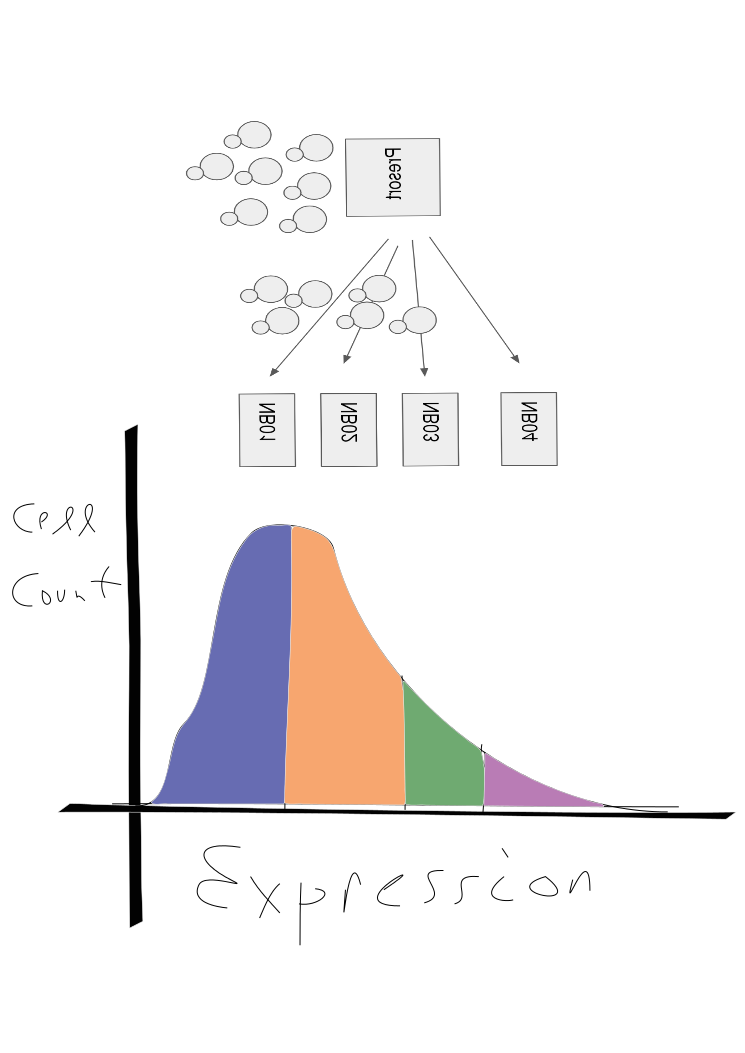


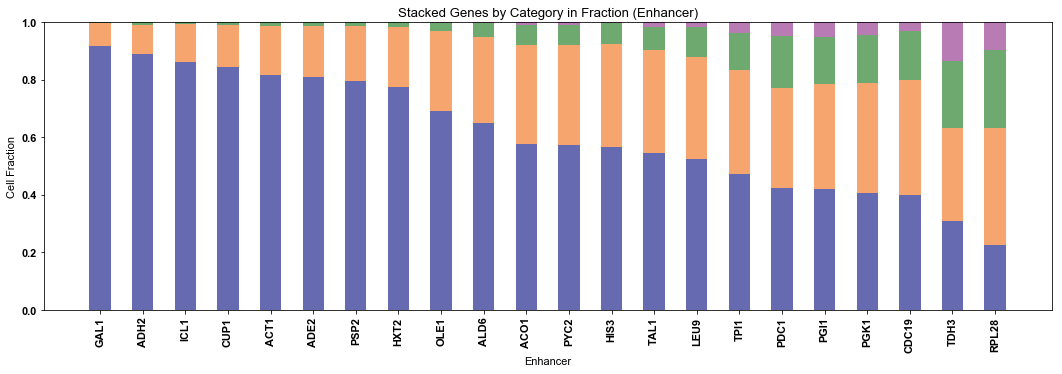

In [100]:
## Fragment prevalence estimation Cib Stacked Histogram
def StackedHist(mat):
    fig      = plt.figure(figsize=(14,4))
    main_ax  = fig.add_axes([1,1,1,1])
    order = scipy.argsort(-mat.NB01)
    x     = scipy.arange (len(mat))
    ##STACKED ALL
    cmap = shiftedColorMap(plt.get_cmap('coolwarm'),0.004,0.2,1,name='shiftedcmap')
    main_ax.bar(x, mat.NB01[order], width=0.5                                                              ,color='#666BB1'    ,align='center')
    main_ax.bar(x, mat.NB02[order], width=0.5, bottom=  mat.NB01[order]                                    ,color='#F7A56E' ,align='center')
    main_ax.bar(x, mat.NB03[order], width=0.5, bottom=  mat.NB01[order] + mat.NB02[order]                  ,color='#6EA970' ,align='center')
    main_ax.bar(x, mat.NB04[order], width=0.5, bottom=  mat.NB01[order] + mat.NB02[order] + mat.NB03[order],color='#B87BB4' ,align='center')
    ticks    = main_ax.xaxis.set_ticks(range(len(mat)))
    labels   = main_ax.xaxis.set_ticklabels(mat.index[order],rotation=90)
    labels   = main_ax.set_xlabel(mat.index.name)
    title    = main_ax.set_title('Stacked Genes by Category in Fraction ({})'.format(mat.index.name))
    labels   = main_ax.set_ylabel('Cell Fraction')
    main_ax.set_ylim([0,1])
    figure = plt.gcf()
    return(figure)

##LOOKING AT LEVELS OF EXPRESSION BY NORMALIZING WITH THE ROW AVERAGES
df              = seqdata[allfeatures].groupby([__ENHANCER__])['NB01','NB02','NB03','NB04'].sum()
Cb              = scipy.array([15663845,6462912,1886385,527069])  
Rb              = df.sum().values
mat             = df[['NB01','NB02','NB03','NB04']].apply(lambda x: x*Cb/Rb/sum(x*Cb/Rb),axis=1)
mat['Evidence'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)
mat             = mat[mat.Evidence > 100]

figure = StackedHist(mat)

# figure.savefig(folder+'StackedHistCellEnhancer.svg', bbox_inches="tight")


# df              = seqdata[allfeatures].groupby([__PROMOTER__])['NB01','NB02','NB03','NB04'].sum()
# Cb              = scipy.array([15663845,6462912,1886385,527069])  
# Rb              = df.sum().values
# mat             = df[['NB01','NB02','NB03','NB04']].apply(lambda x: x*Cb/Rb/sum(x*Cb/Rb),axis=1)
# mat['Evidence'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)
# mat             = mat[mat.Evidence > 100]
# #figure = HistByCategory(mat)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# figure = StackedHist(mat)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure.savefig(folder+'StackedHistCellPromoter.svg', bbox_inches="tight")


# df              = seqdata[allfeatures].groupby([__PRIME5__])['NB01','NB02','NB03','NB04'].sum()
# Cb              = scipy.array([15663845,6462912,1886385,527069])  
# Rb              = df.sum().values
# mat             = df[['NB01','NB02','NB03','NB04']].apply(lambda x: x*Cb/Rb/sum(x*Cb/Rb),axis=1)
# mat['Evidence'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)
# mat             = mat[mat.Evidence > 100]
# #figure = HistByCategory(mat)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# figure = StackedHist(mat)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure.savefig(folder+'StackedHistCellPrime5.svg', bbox_inches="tight")


# df              = seqdata[allfeatures].groupby([__PRIME3__])['NB01','NB02','NB03','NB04'].sum()
# Cb              = scipy.array([15663845,6462912,1886385,527069])  
# Rb              = df.sum().values
# mat             = df[['NB01','NB02','NB03','NB04']].apply(lambda x: x*Cb/Rb/sum(x*Cb/Rb),axis=1)
# mat['Evidence'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)
# mat             = mat[mat.Evidence > 100]
# #figure = HistByCategory(mat)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# figure = StackedHist(mat)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure.savefig(folder+'StackedHistCellPrime3.svg', bbox_inches="tight")


<a id='expression'></a>

## Expression Analysis

C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:571: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[0]:
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:582: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[-2]:
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:587: RuntimeWarning: invalid value encountered in less
  if fxr < fsim[-1]:
C:\ProgramData\Anaconda3\lib\site-packages\scipy\optimize\optimize.py:601: RuntimeWarning: invalid value encountered in less
  if fxcc < fsim[-1]:
C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\scimath.py:120: RuntimeWarning: invalid value encountered in less
  if any(isreal(x) & (x < 0)):
C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:87

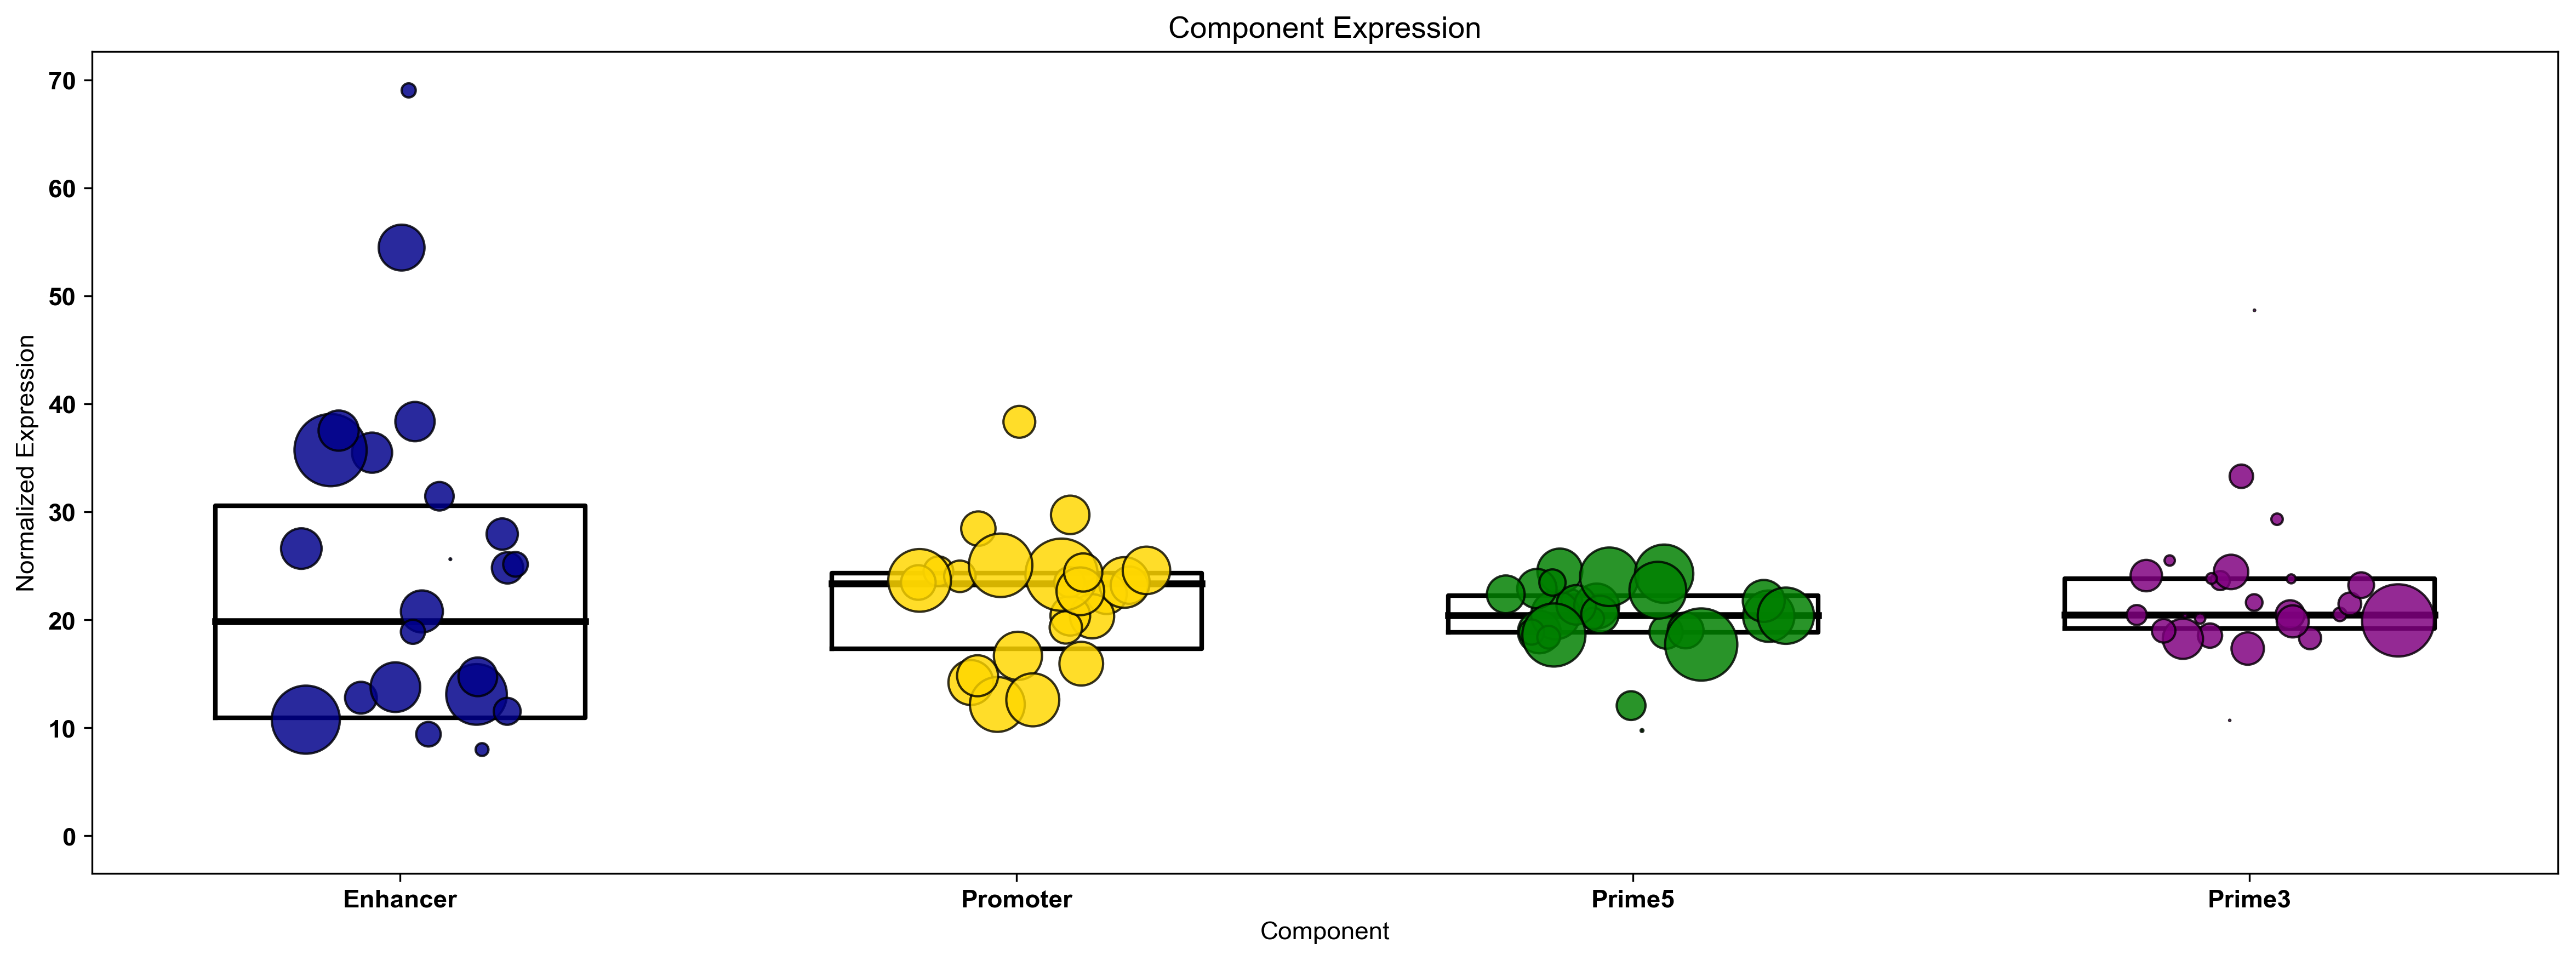

In [103]:
## Do fits for each gragment within each element pooling all reads of all fragments from other elements

ogdf        = seqdata[~nofeatures].groupby([__ENHANCER__,__PROMOTER__,__PRIME5__,__PRIME3__])['presort','NB01','NB02','NB03','NB04'].sum().reset_index()
df          = pandas.melt(ogdf,value_vars=[__ENHANCER__,__PROMOTER__,__PRIME5__,__PRIME3__],id_vars =['presort','NB01','NB02','NB03','NB04'],var_name='Element',value_name='Gene')
df          = df.groupby(['Gene','Element'])[['presort','NB01','NB02','NB03','NB04']].sum()
df['Total'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)

Cb             = scipy.array([15663845,6462912,1886385,527069])  
Rb             = df[['NB01','NB02','NB03','NB04']].sum().values
Cib            = df[['NB01','NB02','NB03','NB04']].apply(lambda x:  x*Cb/Rb/sum(x*Cb/Rb),axis=1).values
df['Score' ]   = scipy.sum(df[['NB01','NB02','NB03','NB04']].apply(lambda x: x/sum(x),axis=1).values * bin_averages,axis=1)/250

df['Evidence'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)
fit2d          = scipy.array([model.fit2d(gene) for gene in Cib])
df['mean2d']   = fit2d[:,0]
df['std2d']    = fit2d[:,1]
df['mean1d']   = scipy.array([model.fit1d(gene) for gene in Cib])




df.Score = df.mean1d
score     = df[df.Total > 100].unstack().Score.fillna(0)
weight    = df[df.Total > 100].unstack().Total.fillna(0)
score = score [[__ENHANCER__,__PROMOTER__,__PRIME5__,__PRIME3__]]
weight= weight[[__ENHANCER__,__PROMOTER__,__PRIME5__,__PRIME3__]]


fig             = plt.figure(figsize=(15,5),dpi=300)
main_ax         = fig.add_axes([1,1,1,1])

medianprops= dict(markeredgecolor='black',color='black',linewidth=3)
boxprops = dict(linewidth=2)
capprops = dict(linewidth=2)
main_ax.boxplot(score.T,whis=[100,0] ,zorder=1,positions = range(4),widths=0.6,medianprops=medianprops,showfliers=False,showcaps=False,boxprops=boxprops,capprops=capprops)

for i,(col,color) in enumerate(zip(score,['darkblue','gold','green','purple'])):
    y       = score [col]
    w       = weight[col]
    x       = [i]*len(y)
    density = scipy.stats.gaussian_kde(y)(y)
    jitter  = scipy.random.rand(len(y))-0.5
    x       = i + (density/max(density) * jitter)/2
    #print(labels[order][i],labels[4],y[labels_map[row_name]],y[4])
    #main_ax.scatter(x[TBP],y[TBP],s=200,color='yellow',zorder=1)
    #main_ax.scatter(x,y,c=colors,s=80,zorder=2)
    #main_ax.scatter(i,y[labels_map[row_name]],s=200,color='black',marker='s',zorder=2)
    main_ax.scatter(x,y,s = w/max(w)*1000,zorder=2,c=color,alpha=0.2)#, facecolors='none',edgecolors='r')
    main_ax.scatter(x,y,s = w/max(w)*1000,zorder=2,c=color,alpha=0.8, facecolors='none',edgecolors='black')

ticks         = main_ax.xaxis.set_ticks(range(len([__ENHANCER__,__PROMOTER__,__PRIME5__,__PRIME3__])))
axis_labels   = main_ax.xaxis.set_ticklabels([__ENHANCER__,__PROMOTER__,__PRIME5__,__PRIME3__],rotation=0)
#lim=main_ax.set_ylim([0,1])
title = main_ax.set_title('Component Expression')
label = main_ax.set_ylabel('Normalized Expression')
label = main_ax.set_xlabel('Component')
big   = plt.gcf()
#big.savefig(folder+'ComponentExpression.svg', bbox_inches="tight")


## Interlude for Plotting Settings and Colormappings

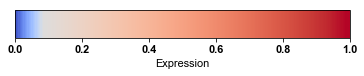

In [93]:
## folder in which figures are autosaved... Also probably not the best way to accomplish this task but again
## its fast and easy.
#folder = r'C:\Users\Robert\Desktop\RO\Figures\\'
#REDBLUECOLORBAR.savefig(folder+'colormap.svg')

##Custom non-centered Color bar definitions
##https://stackoverflow.com/questions/7404116/defining-the-midpoint-of-a-colormap-in-matplotlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])
    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)
        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))
    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)
    return newcmap

REDBLUECOLORBAR, ax = plt.subplots(figsize=(6, 1))
REDBLUECOLORBAR.subplots_adjust(bottom=0.5)
cmap           = shiftedColorMap(plt.get_cmap('coolwarm'),1/350,30/350,1,name='shiftedcmap')
cb1            = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                               # norm=norm,
                                orientation='horizontal')
cb1.set_label('Expression')
# cmap            = shiftedColorMap(plt.get_cmap('coolwarm'),1/350,30/350,1,name='shiftedcmap')
# cmap            = cmap.from_list('binscmap',cmap([0,0.24,0.48,0.99]),4)
# REDBLUEBINS, ax = plt.subplots(figsize=(6, 1))
# fig.subplots_adjust(bottom=0.5)
# #cmap           = shiftedColorMap(plt.get_cmap('coolwarm'),1/350,30/350,1,name='shiftedcmap')
# cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
#                                # norm=norm,
#                                 orientation='horizontal',
#                                 ticks=scipy.array([0.25/2,0.5-0.25/2,0.75-0.25/2,1-0.25/2]))
# cb1.set_label('Expression')
# REDBLUEBINS.savefig(folder+'colormapdiscrete.svg')



C:\ProgramData\Anaconda3\lib\site-packages\numpy\lib\function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


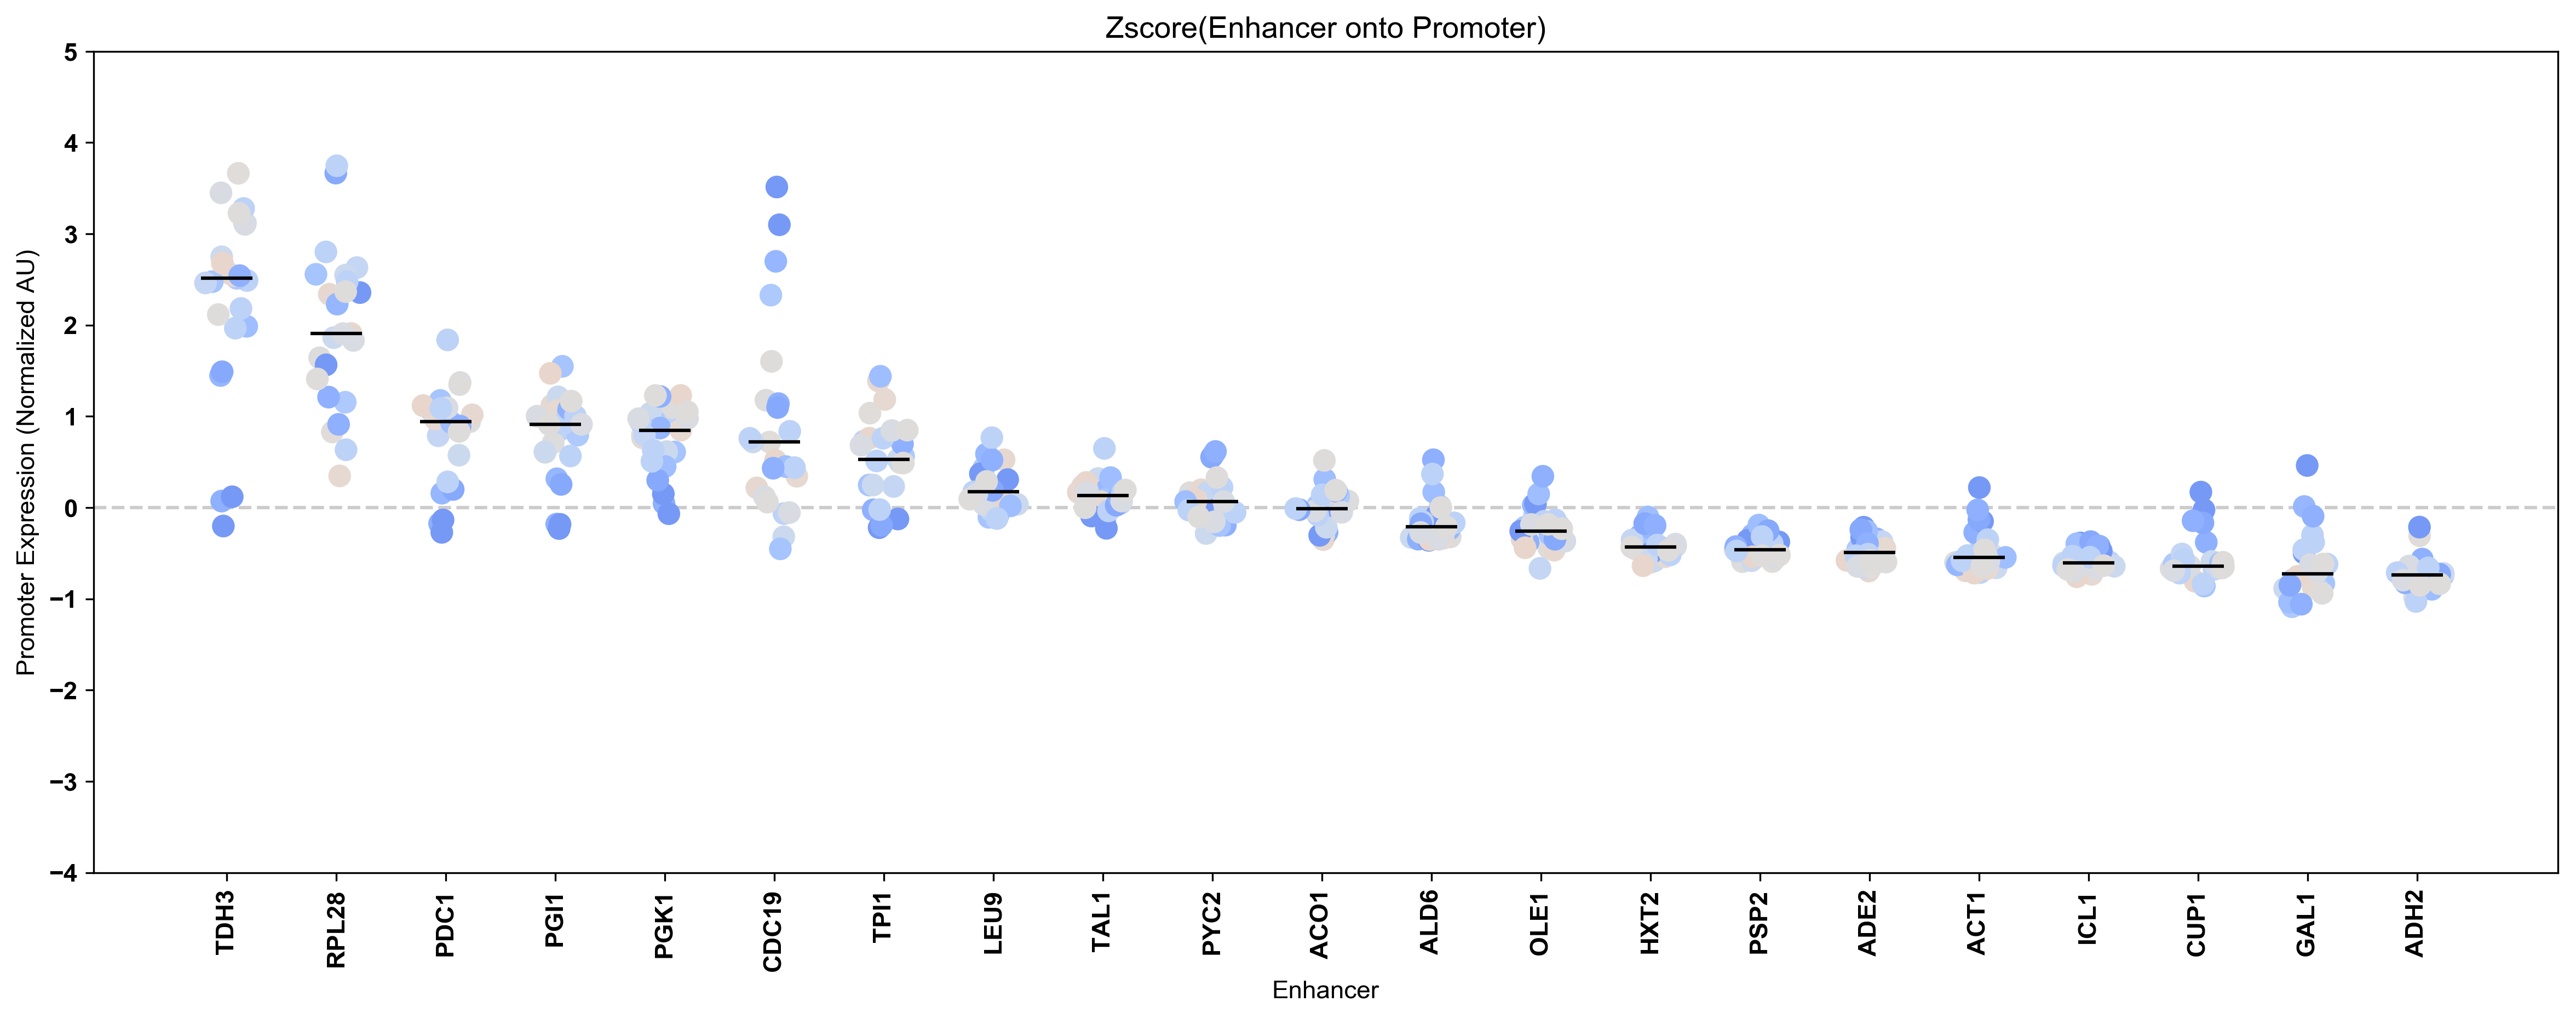

In [25]:
##Szscore plot and calculation
def ZScorePlot(xaxis, yaxis):   
    group = [xaxis,yaxis]
    df             = __DATA__[(xaxis,yaxis)]
    df['Score']    = df['mean2d']/355
    #mat            =  df.Score.unstack(yaxis).values
    df['ZScore']   = df.groupby(yaxis).Score.transform(lambda x: (x-x.mean())/x.std())
    mat            =  df.Score.unstack(yaxis).values
    mat[df.Evidence.unstack(yaxis).values < 100] = scipy.nan

    labels         =  df.index.levels[0]
    labels_map     = {label:i for i,label in enumerate(labels)}
   
    TBP            = scipy.array([labels_map[gene] for gene in __TBP__])
    
    zmat            =  df.ZScore.unstack(yaxis).values
    zmat[df.Evidence.unstack(yaxis).values < 100] = scipy.nan 
    
    rowselect      = (~scipy.isnan(mat).all(axis=1)) & ((mat.shape[1] - scipy.isnan(mat).sum(axis=1)) > 2)         
    mat             = mat[rowselect]
    zmat            = zmat[rowselect]
    xlabels         = labels[rowselect]

    ##GETTING THE SORT ORDER
    means          =  scipy.nanmedian(zmat,axis=1)
    order          =  scipy.argsort  (-means)
    ###############################################
    ##Get opposite Sort order for color############
    omeans         = scipy.nanmedian(mat,axis=0)###
    oorder         = scipy.argsort  (omeans)#######
    cmap           = shiftedColorMap(plt.get_cmap('coolwarm'),1/350,30/350,1,name='shiftedcmap')
    colors         = cmap(   omeans)
    ###############################################
    fig             = plt.figure(figsize=(15,5),dpi=300,)
    main_ax         = fig.add_axes([1,1,1,1])
    main_ax.axhline(0,color='black',alpha = 0.2,linestyle='--',zorder=1)
    for i,row_name in enumerate(xlabels[order]):
        y       = zmat[order][i]
        density = scipy.nan_to_num(scipy.stats.gaussian_kde(y[~scipy.isnan(y)])(y))
        jitter  = scipy.random.rand(len(y))-0.5
        x       = i + (density/max(density) * jitter)/2
        #print(labels[order][i],labels[4],y[labels_map[row_name]],y[4])
        #main_ax.scatter(x[TBP],y[TBP],s=200,color='yellow',zorder=1)
        main_ax.scatter(x,y,c=colors,s=80,zorder=2)
        #main_ax.scatter(i,y[labels_map[row_name]],s=100,color='black',marker='s',zorder=2)
    main_ax.scatter(range(len(means)),means[order],s=500,color='black',marker='_',zorder=2)

    ticks         = main_ax.xaxis.set_ticks(range(len(order)))
    axis_labels   = main_ax.xaxis.set_ticklabels(xlabels[order],rotation=90)
    txt=main_ax.set_title('Zscore'+'({} onto {})'.format(xaxis,yaxis))
    txt=main_ax.set_xlabel(xaxis)
    txt=main_ax.set_ylabel(yaxis + ' Expression (Normalized AU)')
    main_ax.set_ylim([-4,5])
    figure = plt.gcf()
    return(figure)

figure = ZScorePlot(__ENHANCER__,__PROMOTER__)
# figure.savefig(folder+'ZScoreEnhancerPromoter.svg', bbox_inches="tight")


# figure = ZScorePlot(__ENHANCER__,__PRIME3__)
# figure.savefig(folder+'ZScoreEnhancerPrime3.svg', bbox_inches="tight")

# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# figure = ZScorePlot(__ENHANCER__,__PRIME5__)
# figure.savefig(folder+'ZScoreEnhancerPrime5.svg', bbox_inches="tight")

# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# figure = ZScorePlot(__PROMOTER__,__ENHANCER__)
# figure.savefig(folder+'ZScorePromoterEnhancer.svg', bbox_inches="tight")

# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# figure = ZScorePlot(__PROMOTER__,__PRIME3__)
# figure.savefig(folder+'ZScorePromoterPrime3.svg', bbox_inches="tight")

# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# figure = ZScorePlot(__PROMOTER__,__PRIME5__)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300)
# figure.savefig(folder+'ZScorePromoterPrime5.svg', bbox_inches="tight")


# figure = ZScorePlot(__PRIME3__,__PROMOTER__)
# figure.savefig(folder+'ZScorePrime3Promoter.svg', bbox_inches="tight")
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# figure = ZScorePlot(__PRIME3__,__ENHANCER__)
# figure.savefig(folder+'ZScorePrime3Enhancer.svg', bbox_inches="tight")

# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# figure = ZScorePlot(__PRIME3__,__PRIME5__)
# figure.savefig(folder+'ZScorePrime3Prime5.svg', bbox_inches="tight")

# figure = ZScorePlot(__PRIME5__,__PROMOTER__)
# figure.savefig(folder+'ZScorePrime5Promoter.svg', bbox_inches="tight")

# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# figure = ZScorePlot(__PRIME5__,__ENHANCER__)
# figure.savefig(folder+'ZScorePrime5Enhancer.svg', bbox_inches="tight")

# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# figure = ZScorePlot(__PRIME5__,__PRIME3__)
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure.savefig(folder+'ZScorePrime5Prime3.svg', bbox_inches="tight")




C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:30: RuntimeWarning: Mean of empty slice
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


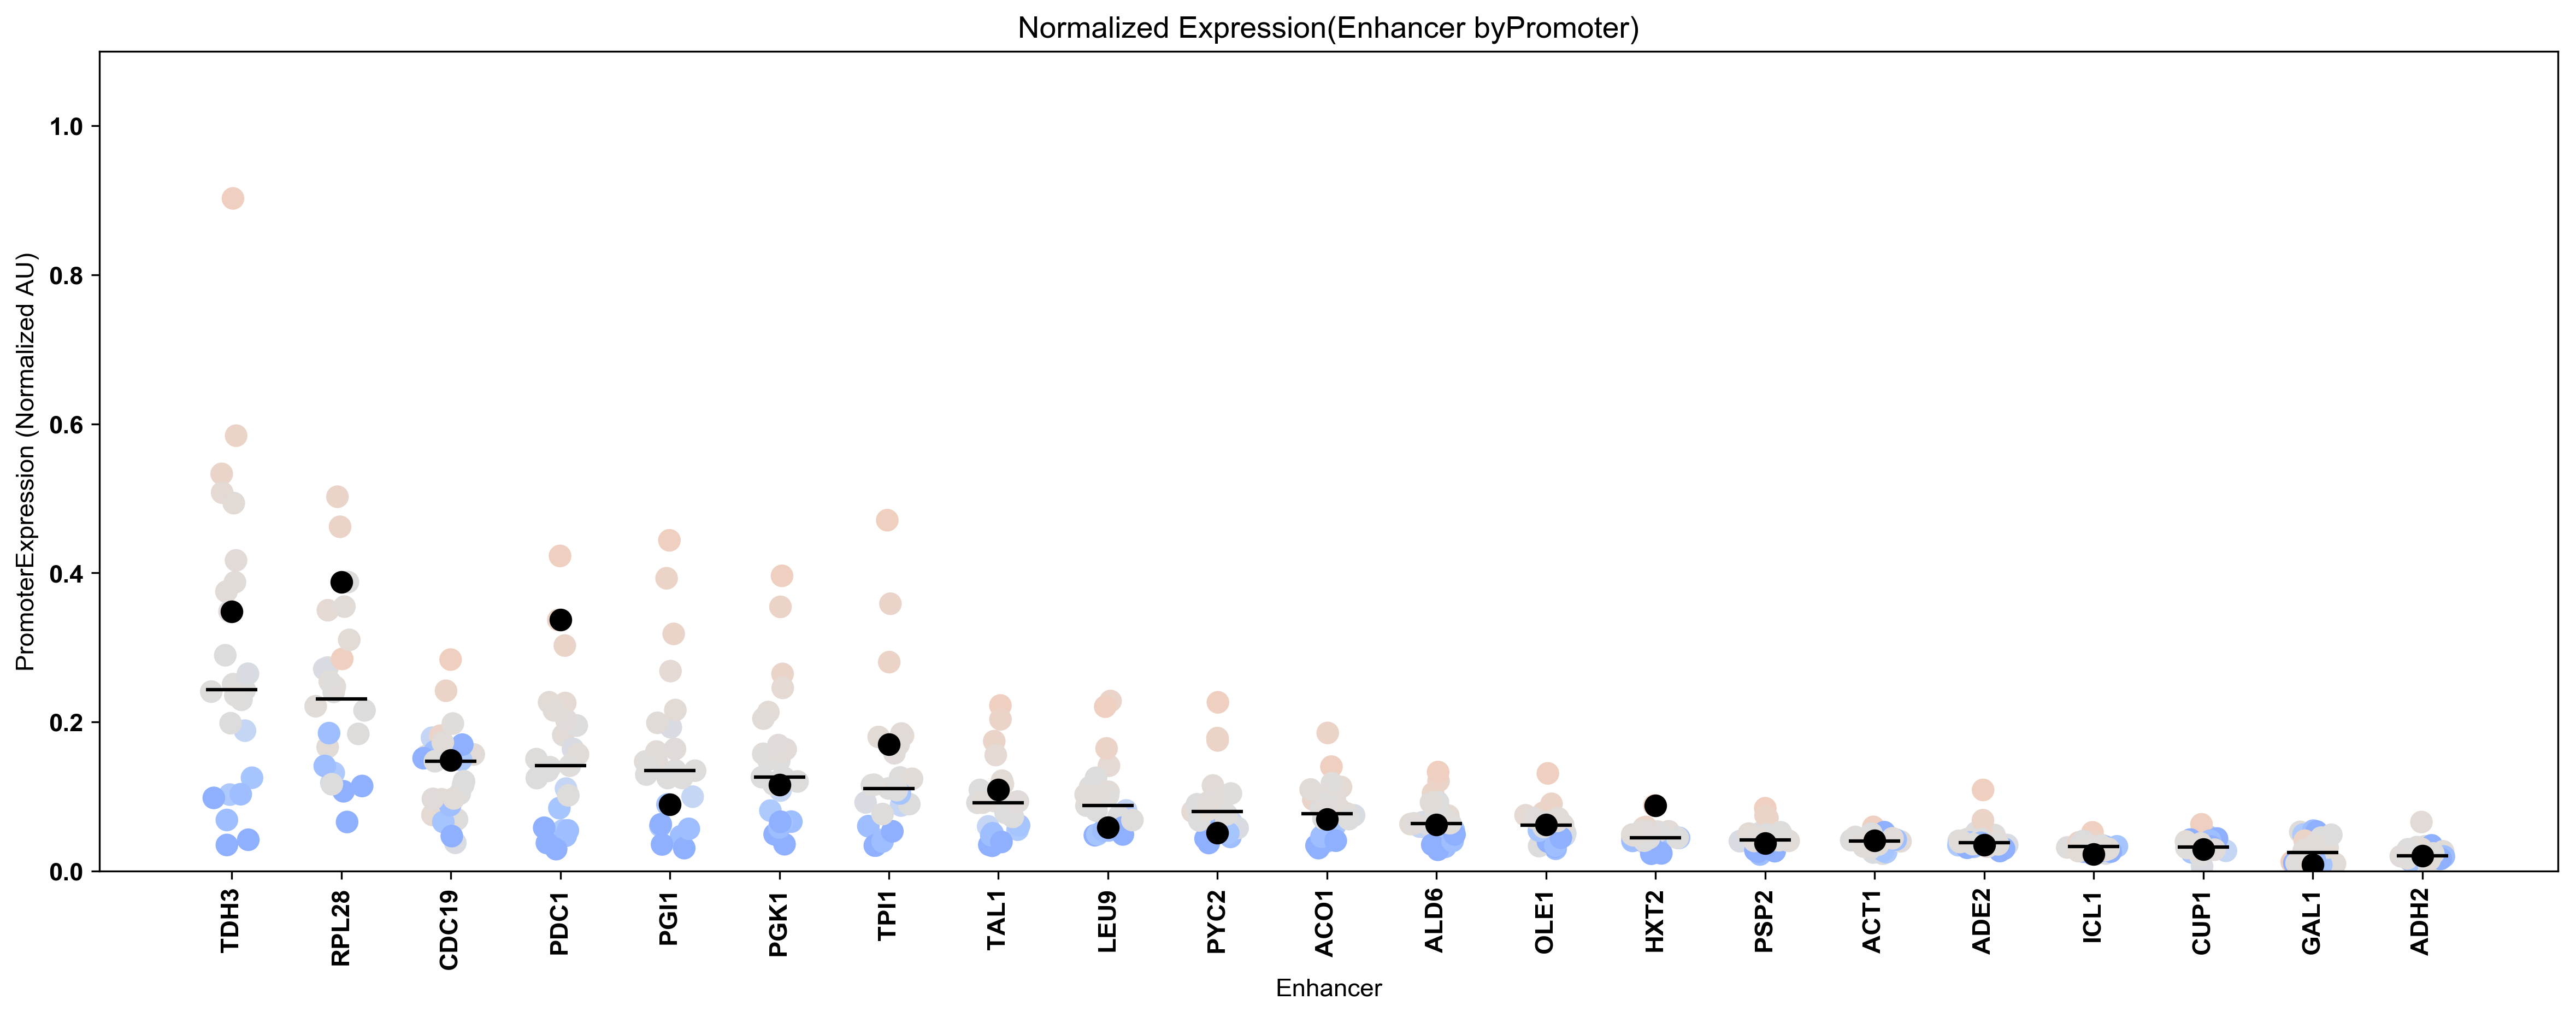

In [23]:
## Analyzing Mean Level Expression for pairs of elements.
def NormalizedExpressionPlot(xaxis, yaxis):
    group = [xaxis,yaxis]
    df             = __DATA__[(xaxis,yaxis)]

    ##Generate fragment labels
    labels         =  df.index.levels[0]
    labels_map     = {label:i for i,label in enumerate(labels)} #fragment labels
    TBP            = scipy.array([labels_map[gene] for gene in __TBP__]) #fragments that have strong tata box

    ## Normalizing data by the mean of the highest expresing bin.
    df['Score']    = df['mean2d']/355
    mat            =  df.Score.unstack(yaxis).values
    ##Remove all Pairs of elements which have less then n reads evidence for that pair
    mat[df.Evidence.unstack(yaxis).values < 100] = scipy.nan

    ##Removing rows which dont have any values and have at least 2 values
    rowselect      = (~scipy.isnan(mat).all(axis=1)) & ((mat.shape[1] - scipy.isnan(mat).sum(axis=1)) > 2)              
    mat            = mat[rowselect]
    xlabels        = labels[rowselect]

    
    ##GETTING THE SORT ORDER on Rows
    ##What is the order of most to least expression.
    means          =  scipy.nanmedian(mat,axis=1)
    order          =  scipy.argsort  (-means)
    ###############################################
    ##Get opposite Sort order for color############
    ##Get the color order for in means of each column.
    omeans         = scipy.nanmean(mat,axis=0)###
    oorder         = scipy.argsort  (omeans)#######
    cmap           = shiftedColorMap(plt.get_cmap('coolwarm'),1/350,30/350,1,name='shiftedcmap')

    colors         = cmap(omeans)
    ###############################################
    
    ##plotting details
    fig             = plt.figure(figsize=(15,5),dpi=300,)
    main_ax         = fig.add_axes([1,1,1,1])

    for i,row_name in enumerate(xlabels[order]):
        y       = mat[order][i]
        density = scipy.nan_to_num(scipy.stats.gaussian_kde(y[~scipy.isnan(y)])(y))
        jitter  = scipy.random.rand(len(y))-0.5
        x       = i + (density/max(density) * jitter)/2
        #print(labels[order][i],labels[4],y[labels_map[row_name]],y[4])
        #main_ax.scatter(x[TBP],y[TBP],s=200,color='yellow',zorder=1)
        main_ax.scatter(x,y,c=colors,s=80)
        main_ax.scatter(i,y[labels_map[row_name]],s=80,color='black')#,#marker='s')
    main_ax.scatter(range(len(means)),means[order],s=500,color='black',marker='_')

    ticks         = main_ax.xaxis.set_ticks(range(len(order)))
    axis_labels   = main_ax.xaxis.set_ticklabels(xlabels[order],rotation=90)
    txt=main_ax.set_title('Normalized Expression'+ '({} by{})'.format(xaxis,yaxis))
    txt=main_ax.set_xlabel(xaxis)
    txt=main_ax.set_ylabel(yaxis + 'Expression (Normalized AU)')
    main_ax.set_ylim([0,1.1])
    figure = plt.gcf()
    return(figure)

figure = NormalizedExpressionPlot(__ENHANCER__,__PROMOTER__)
# figure.savefig(folder+'NormExpressionEnhancerPromoter.svg', bbox_inches="tight")

# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure = NormalizedExpressionPlot(__ENHANCER__,__PRIME5__)
# figure.savefig(folder+'NormExpressionEnhancerPrime5.svg', bbox_inches="tight")

# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure = NormalizedExpressionPlot(__ENHANCER__,__PRIME3__)
# figure.savefig(folder+'NormExpressionEnhancerPrime3.svg', bbox_inches="tight")

# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure = NormalizedExpressionPlot(__PROMOTER__,__ENHANCER__)
# figure.savefig(folder+'NormExpressionPromoterEnhancer.svg', bbox_inches="tight")

# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure = NormalizedExpressionPlot(__PROMOTER__,__PRIME5__)
# figure.savefig(folder+'NormExpressionPromoterPrime5.svg', bbox_inches="tight")

# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure = NormalizedExpressionPlot(__PROMOTER__,__PRIME3__)
# figure.savefig(folder+'NormExpressionPromoterPrime3.svg', bbox_inches="tight")
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# figure = NormalizedExpressionPlot(__PRIME5__,__ENHANCER__)
# figure.savefig(folder+'NormExpressionPrime5Enhancer.svg', bbox_inches="tight")

# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure = NormalizedExpressionPlot(__PRIME5__,__PROMOTER__)
# figure.savefig(folder+'NormExpressionPrime5Promoter.svg', bbox_inches="tight")


# #pdf.savefig(figure, bbox_inches="tight",dpi=300)
# figure = NormalizedExpressionPlot(__PRIME5__  ,__PRIME3__)
# figure.savefig(folder+'NormExpressionPrime5Prime3.svg', bbox_inches="tight")

# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure = NormalizedExpressionPlot(__PRIME3__,__ENHANCER__)
# figure.savefig(folder+'NormExpressionPrime3Enhancer.svg', bbox_inches="tight")
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure = NormalizedExpressionPlot(__PRIME3__,__PROMOTER__)
# figure.savefig(folder+'NormExpressionPrime3Promoter.svg', bbox_inches="tight")
# #pdf.savefig(figure, bbox_inches="tight",dpi=300) 
# figure = NormalizedExpressionPlot(__PRIME3__  ,__PRIME5__)
# figure.savefig(folder+'NormExpressionPrime3Prime5.svg', bbox_inches="tight")

#pdf.savefig(figure, bbox_inches="tight",dpi=300) 

# HeatMaps

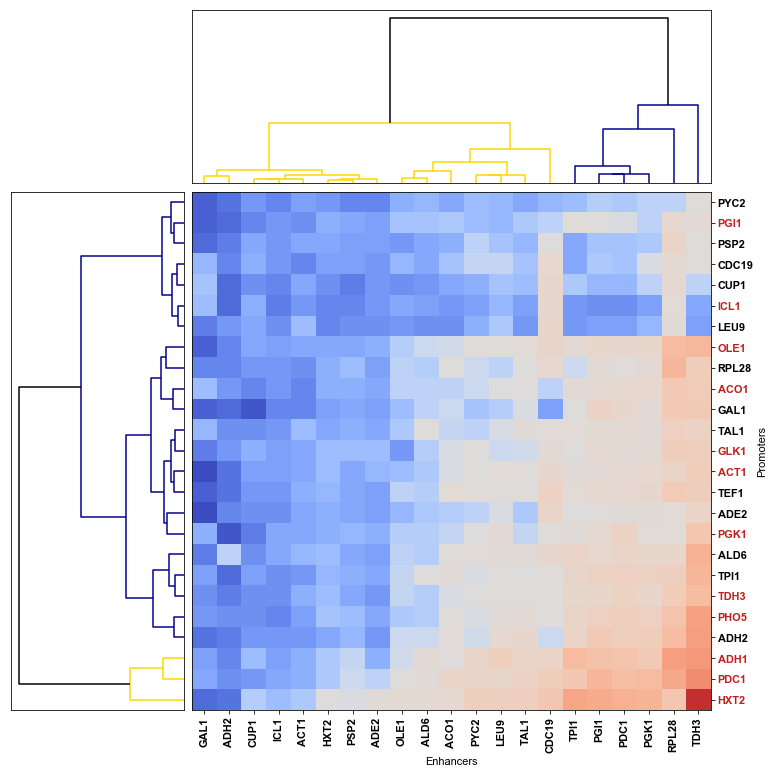

In [27]:
 
def heatmap (matrix, xlabel='Enhancers', ylabel='Promoters',vmin = 0 , vmax = 1,TBP=True):
    """
    Build Heat map and do clustering in both axes.
    """
    # ##IT would seem rows are observation vectors
    linkageL = scipy.cluster.hierarchy.linkage(matrix  , method='ward', metric='euclidean', optimal_ordering=True)
    orderObs = scipy.cluster.hierarchy.leaves_list(linkageL) #The optimal ordering of leaves in clusters
    linkageT = scipy.cluster.hierarchy.linkage(matrix.T, method='ward', metric='euclidean' , optimal_ordering=True)
    orderFeat= scipy.cluster.hierarchy.leaves_list(linkageT) #The optimal ordering of leaves in clusters
    heatmap   = matrix.values[orderObs][:,orderFeat]
    # mask     = scipy.ones_like(matrix)
    # mask[matrix == 0] = scipy.nan
    #heatmap  = matrix.values[orderObs][:,orderFeat] * mask[orderObs][:,orderFeat]

    ##PLOT HEAT MAP WITH CORRESPONDING DENDOGRAMS
    # Compute and plot first dendrogram.
    fig     = plt.figure(figsize=(12,12))
    y_ax    = fig.add_axes([0.09,0.1,0.2,0.6])
    x_ax    = fig.add_axes([0.3,0.71,0.6,0.2])
    main_ax = fig.add_axes([0.3,0.1,0.6,0.6])

    #cmap = plt.cm.Reds
    cmap = shiftedColorMap(plt.get_cmap('coolwarm'),1/350,30/350,1,name='shiftedcmap')
    #cmp=plt.get_cmap('coolwarm')
    #cmap.set_bad('pink',1.)

    # ##ACTUAL DATA INPUT
    scipy.cluster.hierarchy.set_link_color_palette(['gold','darkblue','black','pink'])
    dendoP  = scipy.cluster.hierarchy.dendrogram(linkageL, labels = matrix.index   , ax = y_ax, orientation='left',above_threshold_color='black' )
    dendoE  = scipy.cluster.hierarchy.dendrogram(linkageT, labels = matrix.columns , ax = x_ax, orientation='top',above_threshold_color='black' )


    image   = main_ax.matshow(heatmap,aspect='auto', origin='lower',cmap = cmap,vmin=0,vmax=1)#,norm=matplotlib.colors.LogNorm(vmin=0.004,vmax=1))

    ##FORMATTING
    setticks=[(ax.set_xticks([]),ax.set_yticks([])) for ax in [x_ax,y_ax]]
    main_ax.yaxis.tick_right()
    main_ax.xaxis.tick_bottom()

    main_ax.xaxis.set_ticks(range(len(matrix.columns )))
    xlabels = main_ax.xaxis.set_ticklabels(matrix.columns[orderFeat],rotation='vertical')
    main_ax.yaxis.set_ticks(range(len(matrix.index )))
    ylabels = main_ax.yaxis.set_ticklabels(matrix.index [orderObs])
    main_ax.yaxis.set_label_position('right')
    main_ax.xaxis.set_label_position('bottom')
    if TBP:
        genes_index = dict(zip(matrix.index[orderObs],scipy.arange(len(matrix.index))))
        mat_index   = list(map(genes_index.get, __TBP__  ))
        [main_ax.get_yticklabels()[i].set_color('#BF211E') for i in mat_index if i is not None]

    # genes_index = dict(zip(matrix.columns[orderFeat],scipy.arange(len(matrix.columns))))
    # mat_index   = list(map(genes_index.get, __5ATAC__ ))
    # [main_ax.get_xticklabels()[i].set_color('#BF211E') for i in mat_index if i is not None]

    # genes_index = dict(zip(matrix.columns[orderFeat],scipy.arange(len(matrix.columns))))
    # mat_index   = list(map(genes_index.get, __3ATAC__ ))
    # [main_ax.get_xticklabels()[i].set_color('#E08E45') for i in mat_index if i is not None]
    label=main_ax.set_xlabel(xlabel)
    label=main_ax.set_ylabel(ylabel)
    figure = plt.gcf()
    return(figure)
    
# df             = seqdata[corefeatures].groupby([__ENHANCER__,__PROMOTER__])['NB01','NB02','NB03','NB04'].sum()
# df['Score']    = scipy.sum(df.apply(lambda x: x/sum(x),axis=1).values * bin_averages,axis=1)
# df['ZScore']   = df.groupby(__PROMOTER__).Score.transform(lambda x: (x-x.mean())/x.std())
# df['Evidence'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)
group = (__ENHANCER__,__PROMOTER__)
df             = __DATA__[group]
df['Score']    = df['mean2d']/350

df.Score[df.Evidence < 50] = scipy.nan
matrix    = df.Score.unstack(__ENHANCER__).dropna(axis=0,thresh=15).dropna(axis=1,thresh=15).fillna(0)
fig       = heatmap (matrix,  xlabel='Enhancers', ylabel='Promoters')  
# fig.savefig(folder+'heatmapEnhancersPromoters.svg', bbox_inches="tight")

# group = (__ENHANCER__,__PRIME5__)
# df             = __DATA__[group]
# df['Score']    = df['mean2d']/350
# #mat[df.Evidence.unstack(yaxis).values < 100] = scipy.nan
# df.Score[df.Evidence < 50] = scipy.nan
# #df.Score.unstack(__ENHANCER__).dropna(axis=0,thresh=15).dropna(axis=1,thresh=15)
# matrix    = df.Score.unstack(__ENHANCER__).dropna(axis=0,thresh=15).dropna(axis=1,thresh=15).fillna(0)
# fig       = heatmap (matrix,  xlabel='Enhancers', ylabel='Prime5')  
# #pdf.savefig(fig, bbox_inches="tight",dpi=300) 
# fig.savefig(folder+'heatmapEnhancersPRime5.svg', bbox_inches="tight")

# group = (__ENHANCER__,__PRIME3__)
# df             = __DATA__[group]
# df['Score']    = df['mean2d']/350
# #mat[df.Evidence.unstack(yaxis).values < 100] = scipy.nan
# df.Score[df.Evidence < 50] = scipy.nan
# #df.Score.unstack(__ENHANCER__).dropna(axis=0,thresh=15).dropna(axis=1,thresh=15)
# matrix    = df.Score.unstack(__ENHANCER__).dropna(axis=0,thresh=15).dropna(axis=1,thresh=15).fillna(0)
# fig       = heatmap (matrix,  xlabel='Enhancers', ylabel='Prime3')  
# #pdf.savefig(fig, bbox_inches="tight",dpi=300) 
# fig.savefig(folder+'heatmapEnhancersPrime3.svg', bbox_inches="tight")

# # group = (__PRIME5__,__PRIME3__)
# # df             = __DATA__[group]
# # df['Score']    = df['mean2d']/350
# # #mat[df.Evidence.unstack(yaxis).values < 100] = scipy.nan
# # df.Score[df.Evidence < 50] = scipy.nan
# # #df.Score.unstack(__ENHANCER__).dropna(axis=0,thresh=15).dropna(axis=1,thresh=15)
# # matrix    = df.Score.unstack(__PRIME5__).dropna(axis=0,thresh=15).dropna(axis=1,thresh=15).fillna(0)
# # fig       = heatmap (matrix,  xlabel='Prime5', ylabel='Prime3')  
# # #pdf.savefig(fig, bbox_inches="tight",dpi=300) 
# # # df             = seqdata[allfeatures].groupby([__ENHANCER__,__PRIME5__])['NB01','NB02','NB03','NB04'].sum()
# # # df['Score']    = scipy.sum(df.apply(lambda x: x/sum(x),axis=1).values * bin_averages,axis=1)
# # # df['ZScore']   = df.groupby(__PRIME5__).Score.transform(lambda x: (x-x.mean())/x.std())
# # # df['Evidence'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)
# # # matrix         = df.Score.unstack(__ENHANCER__).dropna(axis=0,thresh=15).dropna(axis=1,thresh=15).fillna(0)

# # # fig       = heatmap (matrix,  xlabel='Enhancers', ylabel='PRIME5',TBP=False)  
# # # #pdf.savefig(fig, bbox_inches="tight",dpi=300) 
# # # fig.savefig(folder+'heatmapEnhancersPrime5.svg', bbox_inches="tight")


# # # df             = seqdata[allfeatures].groupby([__ENHANCER__,__PRIME3__])['NB01','NB02','NB03','NB04'].sum()
# # # df['Score']    = scipy.sum(df.apply(lambda x: x/sum(x),axis=1).values * bin_averages,axis=1)
# # # df['ZScore']   = df.groupby(__PRIME3__).Score.transform(lambda x: (x-x.mean())/x.std())
# # # df['Evidence'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)
# # # matrix         = df.Score.unstack(__ENHANCER__).dropna(axis=0,thresh=15).dropna(axis=1,thresh=15).fillna(0)
# # # fig       = heatmap (matrix,  xlabel='Enhancers', ylabel='PRIME3',TBP=False)  
# # # #pdf.savefig(fig, bbox_inches="tight",dpi=300) 
# # # fig.savefig(folder+'heatmapEnhancersPrime3.svg', bbox_inches="tight")

# # # df             = seqdata[allfeatures].groupby([__PRIME5__,__PRIME3__])['NB01','NB02','NB03','NB04'].sum()
# # # df['Score']    = scipy.sum(df.apply(lambda x: x/sum(x),axis=1).values * bin_averages,axis=1)
# # # df['ZScore']   = df.groupby(__PRIME3__).Score.transform(lambda x: (x-x.mean())/x.std())
# # # df['Evidence'] = df[['NB01','NB02','NB03','NB04']].sum(axis=1)
# # # matrix         = df.Score.unstack(__PRIME5__).dropna(axis=0,thresh=15).dropna(axis=1,thresh=15).fillna(0)
# # # fig       = heatmap (matrix,  xlabel='Enhancers', ylabel='PRIME3',TBP=False)  
# # # #pdf.savefig(fig, bbox_inches="tight",dpi=300) 
# # # fig.savefig(folder+'heatmapPrime5Prime3.svg', bbox_inches="tight")


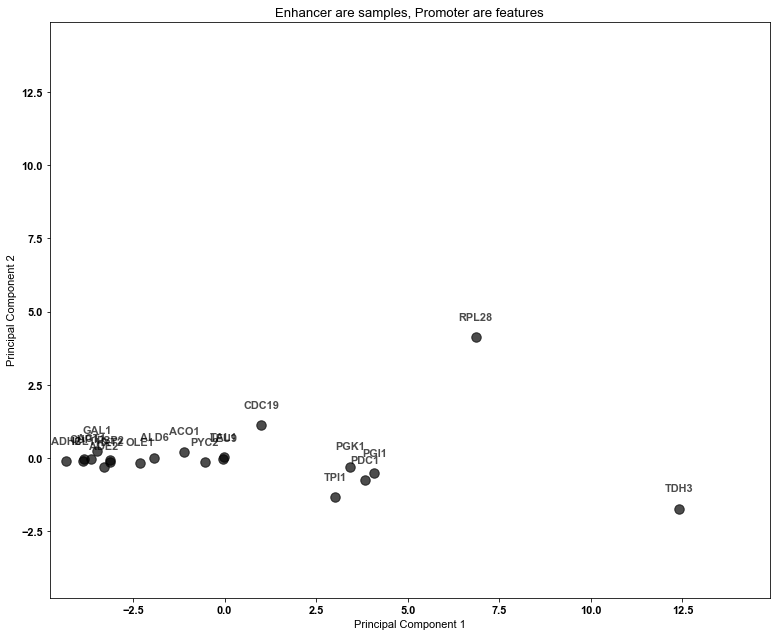

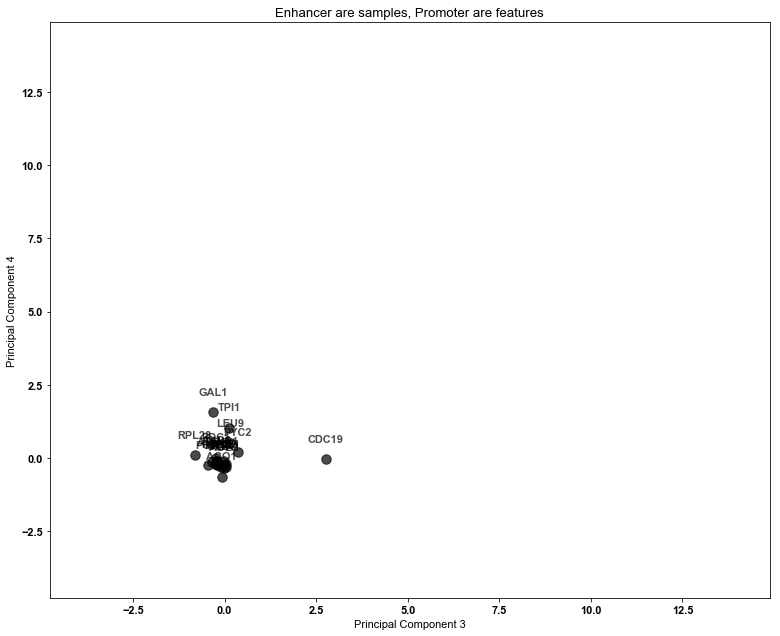

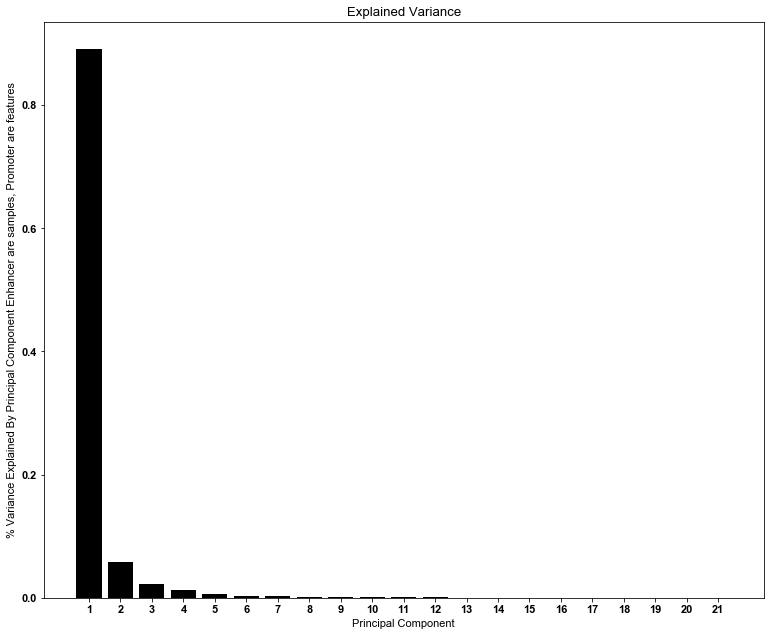

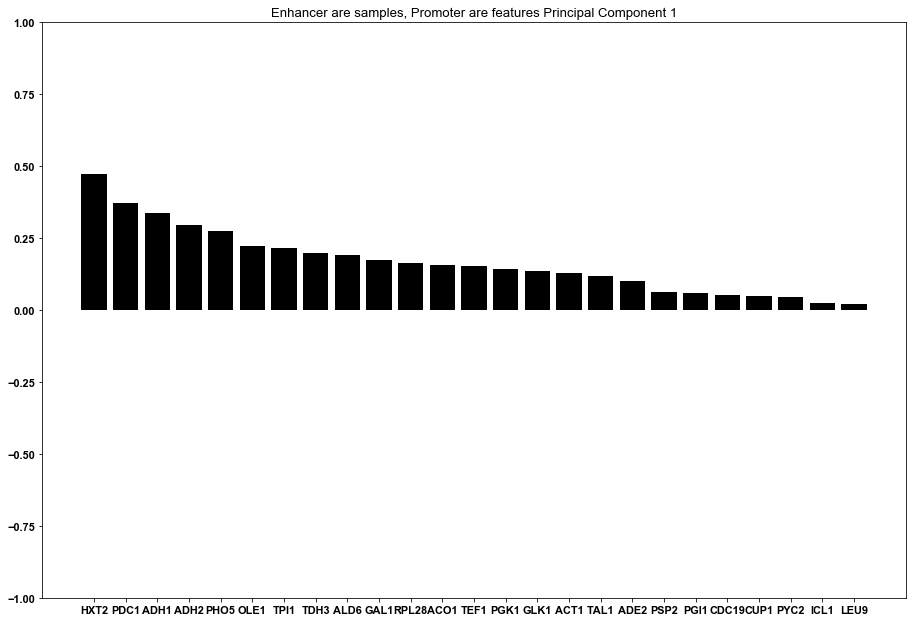

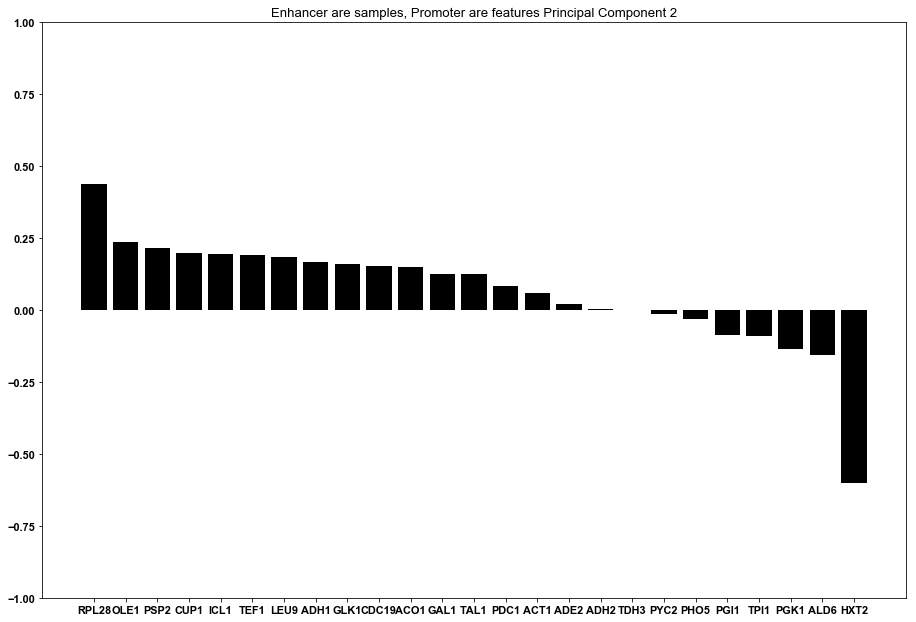

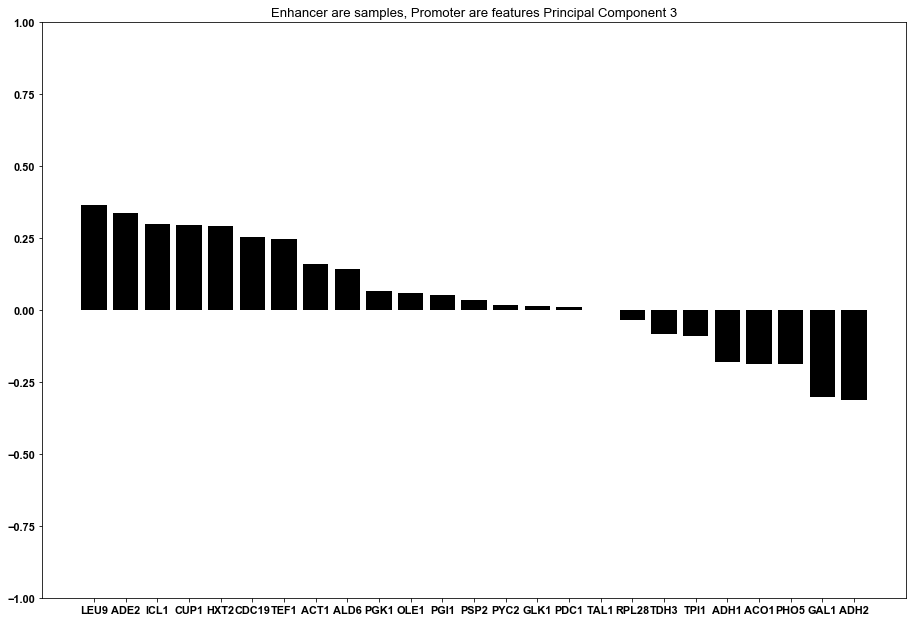

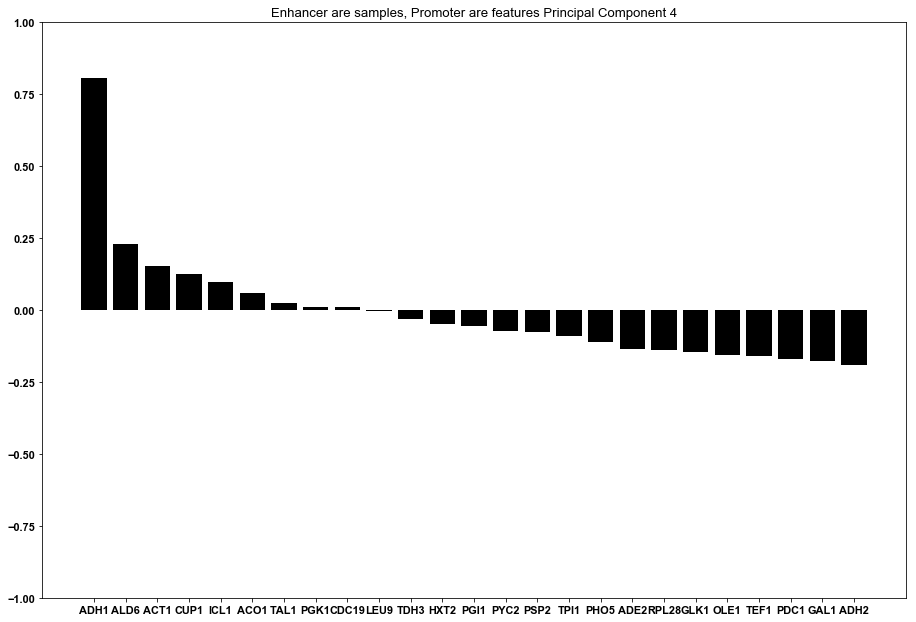

In [23]:
def PCAPLOTS(PCA, X, Y, W, Z, features, samples, flabels, slabels):
    tits = '{} are samples, {} are features'.format(samples,features)
    figures = []
    fig      = plt.figure(figsize=(10,8))
    main_ax  = fig.add_axes([1,1,1,1])
    main_ax.scatter(X, Y,color='black',s=90,alpha=0.7)
    xmax,xmin = max([max(X),max(Y)]),min([min(X),min(Y)])
    xmax,xmin = xmax+xmax*0.2, xmin+xmin*0.1
    main_ax.set_xlabel('Principal Component 1')
    main_ax.set_ylabel('Principal Component 2')
    main_ax.set_xlim([xmin,xmax])
    main_ax.set_ylim([xmin,xmax])
    yspan = main_ax.get_ylim()[1]- main_ax.get_ylim()[0]
    for i, txt in enumerate(slabels):
        main_ax.annotate(txt, (X[i], Y[i]+yspan * 0.03),alpha=0.7,horizontalalignment='center')
    main_ax.set_title(tits)
   
    
    figures.append(fig)
    
    fig      = plt.figure(figsize=(10,8))
    main_ax  = fig.add_axes([1,1,1,1])
    main_ax.scatter(W, Z,color='black',s=90,alpha=0.7)
    main_ax.set_xlabel('Principal Component 3')
    main_ax.set_ylabel('Principal Component 4')
    main_ax.set_xlim([xmin,xmax])
    main_ax.set_ylim([xmin,xmax])
    yspan = main_ax.get_ylim()[1]- main_ax.get_ylim()[0]
    for i, txt in enumerate(slabels):
        main_ax.annotate(txt, (W[i], Z[i]+yspan * 0.03), alpha=0.7, horizontalalignment='center')
    main_ax.set_title(tits)
 

    figures.append(fig)
    
    ##Contribution of one component to determining expression from enhancers
    fig      = plt.figure(figsize=(10,8))
    main_ax  = fig.add_axes([1,1,1,1])
    main_ax.bar(scipy.arange(len(PCA.explained_variance_ratio_))+1, PCA.explained_variance_ratio_,color='black')
    ticks=main_ax.set_xticks(scipy.arange(len(PCA.explained_variance_ratio_))+1)
    label=main_ax.set_xlabel('Principal Component')
    label=main_ax.set_ylabel('% Variance Explained By Principal Component {}'.format(tits))
    title=main_ax.set_title('Explained Variance')
    
    figures.append(fig)
    for i,component in enumerate(PCA.components_[0:4]):
        fig      = plt.figure(figsize=(12,8))
        main_ax  = fig.add_axes([1,1,1,1])
        order    = scipy.argsort(-component)
        bar      = main_ax.bar(scipy.arange(len(component)), component[order],color='black')
        xticks   = main_ax.set_xticks(scipy.arange(len(component)))
        xlabels  = main_ax.xaxis.set_ticklabels(flabels[order])
        title    = main_ax.set_title('{} Principal Component {}'.format(tits,i+1))
        ylim     = main_ax.set_ylim([-1,1])
        figures.append(fig)
    return(figures)

def DOPCA(features, samples):
    df             = __DATA__[(features,samples)]
    #df['Score']    = df['Score*']
    df['Score']   = df['mean2d'].transform(lambda x: (x-x.mean())/x.std())

    #mat[df.Evidence.unstack(yaxis).values < 100] = scipy.nan
    df.Score[df.Evidence < 100] = scipy.nan
    pairselection  = df.Evidence >100
    selection = pairselection
    df          = df[selection].Score.unstack(features).dropna(axis=0,thresh=12).dropna(axis=1,how='any',thresh=18).stack()
    fmatrix     = df.unstack(features ).apply(lambda x: x-scipy.nanmedian(x))
    smatrix     = df.unstack(samples  ).apply(lambda x: x-scipy.nanmedian(x))
    slabels     = fmatrix.index
    flabels     = fmatrix.columns

    imputer = sklearn.impute.SimpleImputer(strategy='mean')
    fmatrix = imputer.fit_transform(fmatrix)
    smatrix = imputer.fit_transform(smatrix)

    ##CONGRADULATIONS You discovered I attempted a non-linear dimensionality reduction as well.
    ##Maybe there are clusters(t-sne is hard to interperate.) but one trend that seems certain is the linear relationship. 
    
    #from sklearn.manifold import TSNE
    #Y = TSNE(n_components=2,perplexity=3,n_iter=10000).fit_transform(fmatrix)
    
    PCA      = sklearn.decomposition.PCA(n_components=None)
    PCA.fit(fmatrix)
    X,Y,W,Z = PCA.transform(fmatrix)[:,:4].T
    return(PCA, X, Y, W, Z, features, samples, flabels, slabels)





PCA = DOPCA(samples = __ENHANCER__, features  = __PROMOTER__)
figures = PCAPLOTS(*PCA)
# for fig,name in zip(figures,['PCA_1X2_{}','PCA_3X4_{}','PCA_ExplainedVar_{}','PCA_Vector1_{}','PCA_Vector2_{}','PCA_Vector3_{}','PCA_Vector4_{}']):
#     fig.savefig(folder+name.format('{samples}Samples{features}Features.svg'.format( features=__ENHANCER__, samples  = __PROMOTER__)),bbox_inches="tight")

# PCA = DOPCA(samples = __ENHANCER__, features  = __PRIME5__)
# figures = PCAPLOTS(*PCA)
# for fig,name in zip(figures,['PCA_1X2_{}','PCA_3X4_{}','PCA_ExplainedVar_{}','PCA_Vector1_{}','PCA_Vector2_{}','PCA_Vector3_{}','PCA_Vector4_{}']):
#     fig.savefig(folder+name.format('{samples}Samples{features}Features.svg'.format(features = __ENHANCER__, samples  = __PRIME5__)),bbox_inches="tight")

# PCA = DOPCA(samples = __ENHANCER__, features  = __PRIME3__)
# figures = PCAPLOTS(*PCA)
# for fig,name in zip(figures,['PCA_1X2_{}','PCA_3X4_{}','PCA_ExplainedVar_{}','PCA_Vector1_{}','PCA_Vector2_{}','PCA_Vector3_{}','PCA_Vector4_{}']):
#     fig.savefig(folder+name.format('{samples}Samples{features}Features.svg'.format(features = __ENHANCER__, samples  = __PRIME3__)),bbox_inches="tight")


# PCA = DOPCA(samples = __PROMOTER__, features  = __ENHANCER__)
# figures = PCAPLOTS(*PCA)
# for fig,name in zip(figures,['PCA_1X2_{}','PCA_3X4_{}','PCA_ExplainedVar_{}','PCA_Vector1_{}','PCA_Vector2_{}','PCA_Vector3_{}','PCA_Vector4_{}']):
#     fig.savefig(folder+name.format('{samples}Samples{features}Features.svg'.format(features = __PROMOTER__, samples  = __ENHANCER__)),bbox_inches="tight")

# PCA = DOPCA(samples = __PROMOTER__, features  = __PRIME5__)
# figures = PCAPLOTS(*PCA)
# for fig,name in zip(figures,['PCA_1X2_{}','PCA_3X4_{}','PCA_ExplainedVar_{}','PCA_Vector1_{}','PCA_Vector2_{}','PCA_Vector3_{}','PCA_Vector4_{}']):
#     fig.savefig(folder+name.format('{samples}Samples{features}Features.svg'.format(features = __PROMOTER__, samples  = __PRIME5__)),bbox_inches="tight")

# PCA = DOPCA(samples = __PROMOTER__, features  = __PRIME3__)
# figures = PCAPLOTS(*PCA)
# for fig,name in zip(figures,['PCA_1X2_{}','PCA_3X4_{}','PCA_ExplainedVar_{}','PCA_Vector1_{}','PCA_Vector2_{}','PCA_Vector3_{}','PCA_Vector4_{}']):
#     fig.savefig(folder+name.format('{samples}Samples{features}Features.svg'.format(features = __PROMOTER__, samples  = __PRIME3__)),bbox_inches="tight")




# PCA = DOPCA(samples = __PRIME5__, features  = __ENHANCER__)
# figures = PCAPLOTS(*PCA)
# for fig,name in zip(figures,['PCA_1X2_{}','PCA_3X4_{}','PCA_ExplainedVar_{}','PCA_Vector1_{}','PCA_Vector2_{}','PCA_Vector3_{}','PCA_Vector4_{}']):
#     fig.savefig(folder+name.format('{samples}Samples{features}Features.svg'.format(features = __PRIME5__, samples  = __ENHANCER__)),bbox_inches="tight")


# PCA = DOPCA(samples = __PRIME5__, features  = __PROMOTER__)
# figures = PCAPLOTS(*PCA)
# for fig,name in zip(figures,['PCA_1X2_{}','PCA_3X4_{}','PCA_ExplainedVar_{}','PCA_Vector1_{}','PCA_Vector2_{}','PCA_Vector3_{}','PCA_Vector4_{}']):
#     fig.savefig(folder+name.format('{samples}Samples{features}Features.svg'.format(features = __PRIME5__, samples  = __PROMOTER__)),bbox_inches="tight")


# PCA = DOPCA(samples = __PRIME5__, features  = __PRIME3__)
# figures = PCAPLOTS(*PCA)
# for fig,name in zip(figures,['PCA_1X2_{}','PCA_3X4_{}','PCA_ExplainedVar_{}','PCA_Vector1_{}','PCA_Vector2_{}','PCA_Vector3_{}','PCA_Vector4_{}']):
#     fig.savefig(folder+name.format('{samples}Samples{features}Features.svg'.format(features = __PRIME5__, samples  = __PRIME3__)),bbox_inches="tight")



# PCA = DOPCA(samples = __PRIME3__, features  = __ENHANCER__)
# figures = PCAPLOTS(*PCA)
# for fig,name in zip(figures,['PCA_1X2_{}','PCA_3X4_{}','PCA_ExplainedVar_{}','PCA_Vector1_{}','PCA_Vector2_{}','PCA_Vector3_{}','PCA_Vector4_{}']):
#     fig.savefig(folder+name.format('{samples}Samples{features}Features.svg'.format(features = __PRIME3__, samples  = __ENHANCER__)),bbox_inches="tight")

# PCA = DOPCA(samples = __PRIME3__, features  = __PROMOTER__)
# figures = PCAPLOTS(*PCA)
# for fig,name in zip(figures,['PCA_1X2_{}','PCA_3X4_{}','PCA_ExplainedVar_{}','PCA_Vector1_{}','PCA_Vector2_{}','PCA_Vector3_{}','PCA_Vector4_{}']):
#     fig.savefig(folder+name.format('{samples}Samples{features}Features.svg'.format(features = __PRIME3__, samples  = __PROMOTER__)),bbox_inches="tight")

# PCA = DOPCA(samples = __PRIME3__, features  = __PRIME5__)
# figures = PCAPLOTS(*PCA)
# for fig,name in zip(figures,['PCA_1X2_{}','PCA_3X4_{}','PCA_ExplainedVar_{}','PCA_Vector1_{}','PCA_Vector2_{}','PCA_Vector3_{}','PCA_Vector4_{}']):
#     fig.savefig(folder+name.format('{samples}Samples{features}Features.svg'.format(features = __PRIME3__, samples  = __PRIME5__)),bbox_inches="tight")



<a id='9x9'></a>

## Analysis of 9x9
1) Log2 Fold change

2) HeatMap

3) z-score plots

In [4]:
raw                 = pandas.read_csv(r'C:\Users\Robert\Desktop\RO\melted.csv')
micdata             = raw.copy()
micdata.Intensity   = pandas.to_numeric(micdata.Intensity)
micdata[__IV__ ]    = (micdata.Intensity - micdata.Vector ).clip(0)
micdata[__SUMNORMALIZED__     ]= micdata.groupby([__EXPERIMENT__ ,__REPLICATE__ ,__CONDITION__]).I_V.transform(lambda x: x/x.sum()*100)
micdata[__MAXNORMALIZED__     ]= micdata.groupby([__EXPERIMENT__ ,__REPLICATE__ ,__CONDITION__]).I_V.transform(lambda x: x/x.max()*100)
micdata[__PROMOTERNORMALIZED__]= micdata.groupby([__EXPERIMENT__ ,__REPLICATE__ ,__CONDITION__,__PROMOTER__]).I_V.transform(lambda x:(x-x.mean())/x.std())
micdata[__ENHANCERNORMALIZED__]= micdata.groupby([__EXPERIMENT__ ,__REPLICATE__ ,__CONDITION__,__ENHANCER__]).I_V.transform(lambda x:(x-x.mean())/x.std())


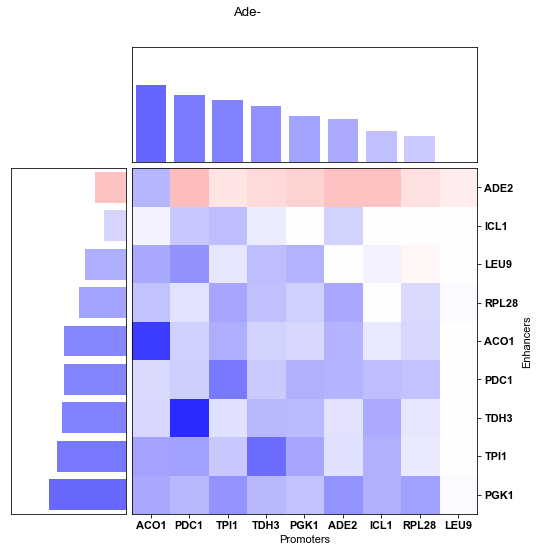

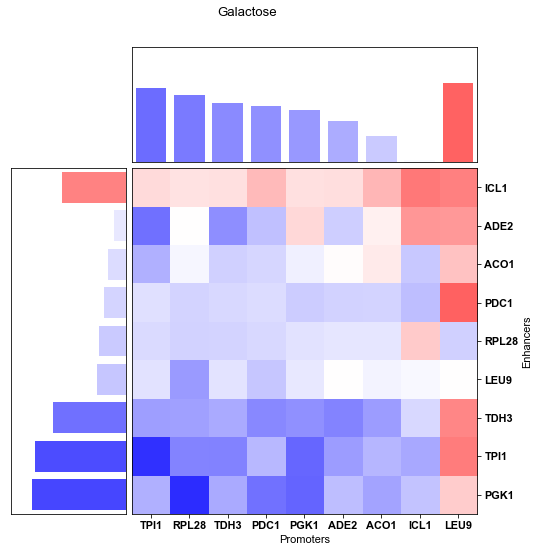

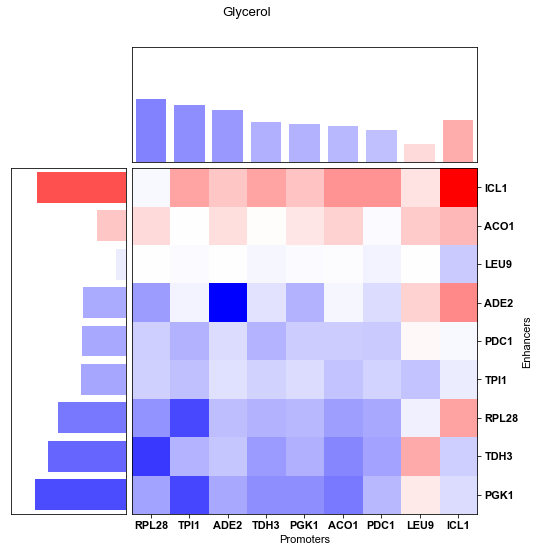

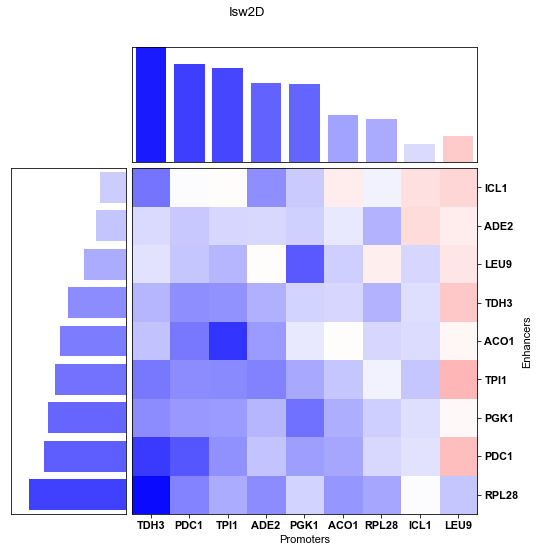

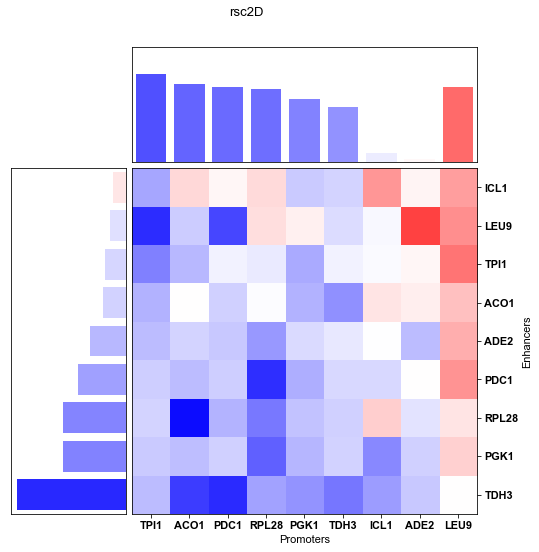

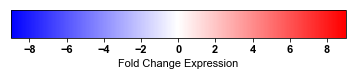

In [9]:
df       = micdata.groupby([__ENHANCER__,__PROMOTER__,__CONDITION__]).mean().reset_index() ##Grouping Replicates
df       = df.pivot_table(index=[__ENHANCER__,__PROMOTER__], columns=__CONDITION__,values  = __SUMNORMALIZED__) 
df       = df[['Ade-','Galactose','Glycerol','Isw2D','Mot1-1_32C_4h','Rsc2D']].apply(lambda x: scipy.log2(  scipy.absolute(x/df.Glucose.values-1)  ),axis=0) 
ade      = df['Ade-'     ].unstack(__PROMOTER__)
gal      = df['Galactose'].unstack(__PROMOTER__)
gly      = df['Glycerol'] .unstack(__PROMOTER__)
isw      = df['Isw2D']    .unstack(__PROMOTER__)
mot      = df['Mot1-1_32C_4h']    .unstack(__PROMOTER__)
rsc      = df['Rsc2D']    .unstack(__PROMOTER__)

title     =  ['Ade-','Galactose','Glycerol','Isw2D','rsc2D']
heatmaps  =  [ade.values,gal.values,gly.values,isw.values,rsc.values]
cmax,cmin =   9,-9#max(df.values.flatten()),min(df.values.flatten())


for title,heatmap in zip(title,heatmaps):
    genes   = df.index.levels[0]
    # Compute and plot first dendrogram.
    fig     = plt.figure(figsize=(8,8))
    y_ax    = fig.add_axes([0.09,0.1,0.2,0.6])
    x_ax    = fig.add_axes([0.3,0.71,0.6,0.2])
    main_ax = fig.add_axes([0.3,0.1,0.6,0.6])
    main_ax.get_shared_x_axes().join(main_ax, x_ax)
    main_ax.get_shared_y_axes().join(main_ax, y_ax)
    #main_ax = fig.add_axes([0,0,1,1])
    
    ##COLORS
    cmap = plt.get_cmap('bwr')
    cmap.set_bad('black',1.)
    #cmax = max(scipy.absolute(heatmap).flatten())

    ##ORDERINGS
    emeans = heatmap.mean(axis=1)
    pmeans = heatmap.mean(axis=0)
    eorder = scipy.argsort(emeans)
    porder = scipy.argsort(pmeans)

    image   = main_ax.matshow(heatmap[eorder][:,porder],aspect='auto',cmap=cmap, origin='lower',vmin=cmin, vmax=cmax)
    ehist   = y_ax.barh(scipy.arange(len(genes)),scipy.absolute(emeans[eorder]),align='center',color=cmap(emeans[eorder]/cmax + 0.5))
    ehist   = x_ax.bar (scipy.arange(len(genes)),scipy.absolute(pmeans[porder]),align='center',color=cmap(pmeans[porder]/cmax + 0.5))
    
    y_ax.invert_xaxis()
    main_ax.set_ylim([-0.5,len(genes)-0.5])
    main_ax.set_xlim([-0.5,len(genes)-0.5])
    y_ax.set_xlim([4,0])
    x_ax.set_ylim([0,4])

    
    ##FORMATTING
    setticks=[(ax.set_xticks([]),ax.set_yticks([])) for ax in [x_ax,y_ax]]
    main_ax.yaxis.tick_right()
    main_ax.xaxis.tick_bottom()
    main_ax.xaxis.set_ticks(range(len(genes)))
    xlabels = main_ax.xaxis.set_ticklabels(genes[porder])
    main_ax.yaxis.set_ticks(range(len(genes)))
    ylabels = main_ax.yaxis.set_ticklabels(genes[eorder])
    main_ax.yaxis.set_label_position('right')
    main_ax.xaxis.set_label_position('bottom')
    label=main_ax.set_xlabel('Promoters')
    label=main_ax.set_ylabel('Enhancers')
    text = fig.suptitle(title)
    figure = plt.gcf()
    #figure.savefig(folder+'HeatMapCondition_{}_.svg'.format(title), bbox_inches="tight")


##COLORBAR    
fig, ax = plt.subplots(figsize=(6, 1))
fig.subplots_adjust(bottom=0.5)
cmap = plt.get_cmap('bwr')
norm = matplotlib.colors.Normalize(vmin=cmin, vmax=cmax)
cb1 = matplotlib.colorbar.ColorbarBase(ax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_label('Fold Change Expression')
#fig.savefig(folder+'colorbarFoldChange.svg', bbox_inches="tight")


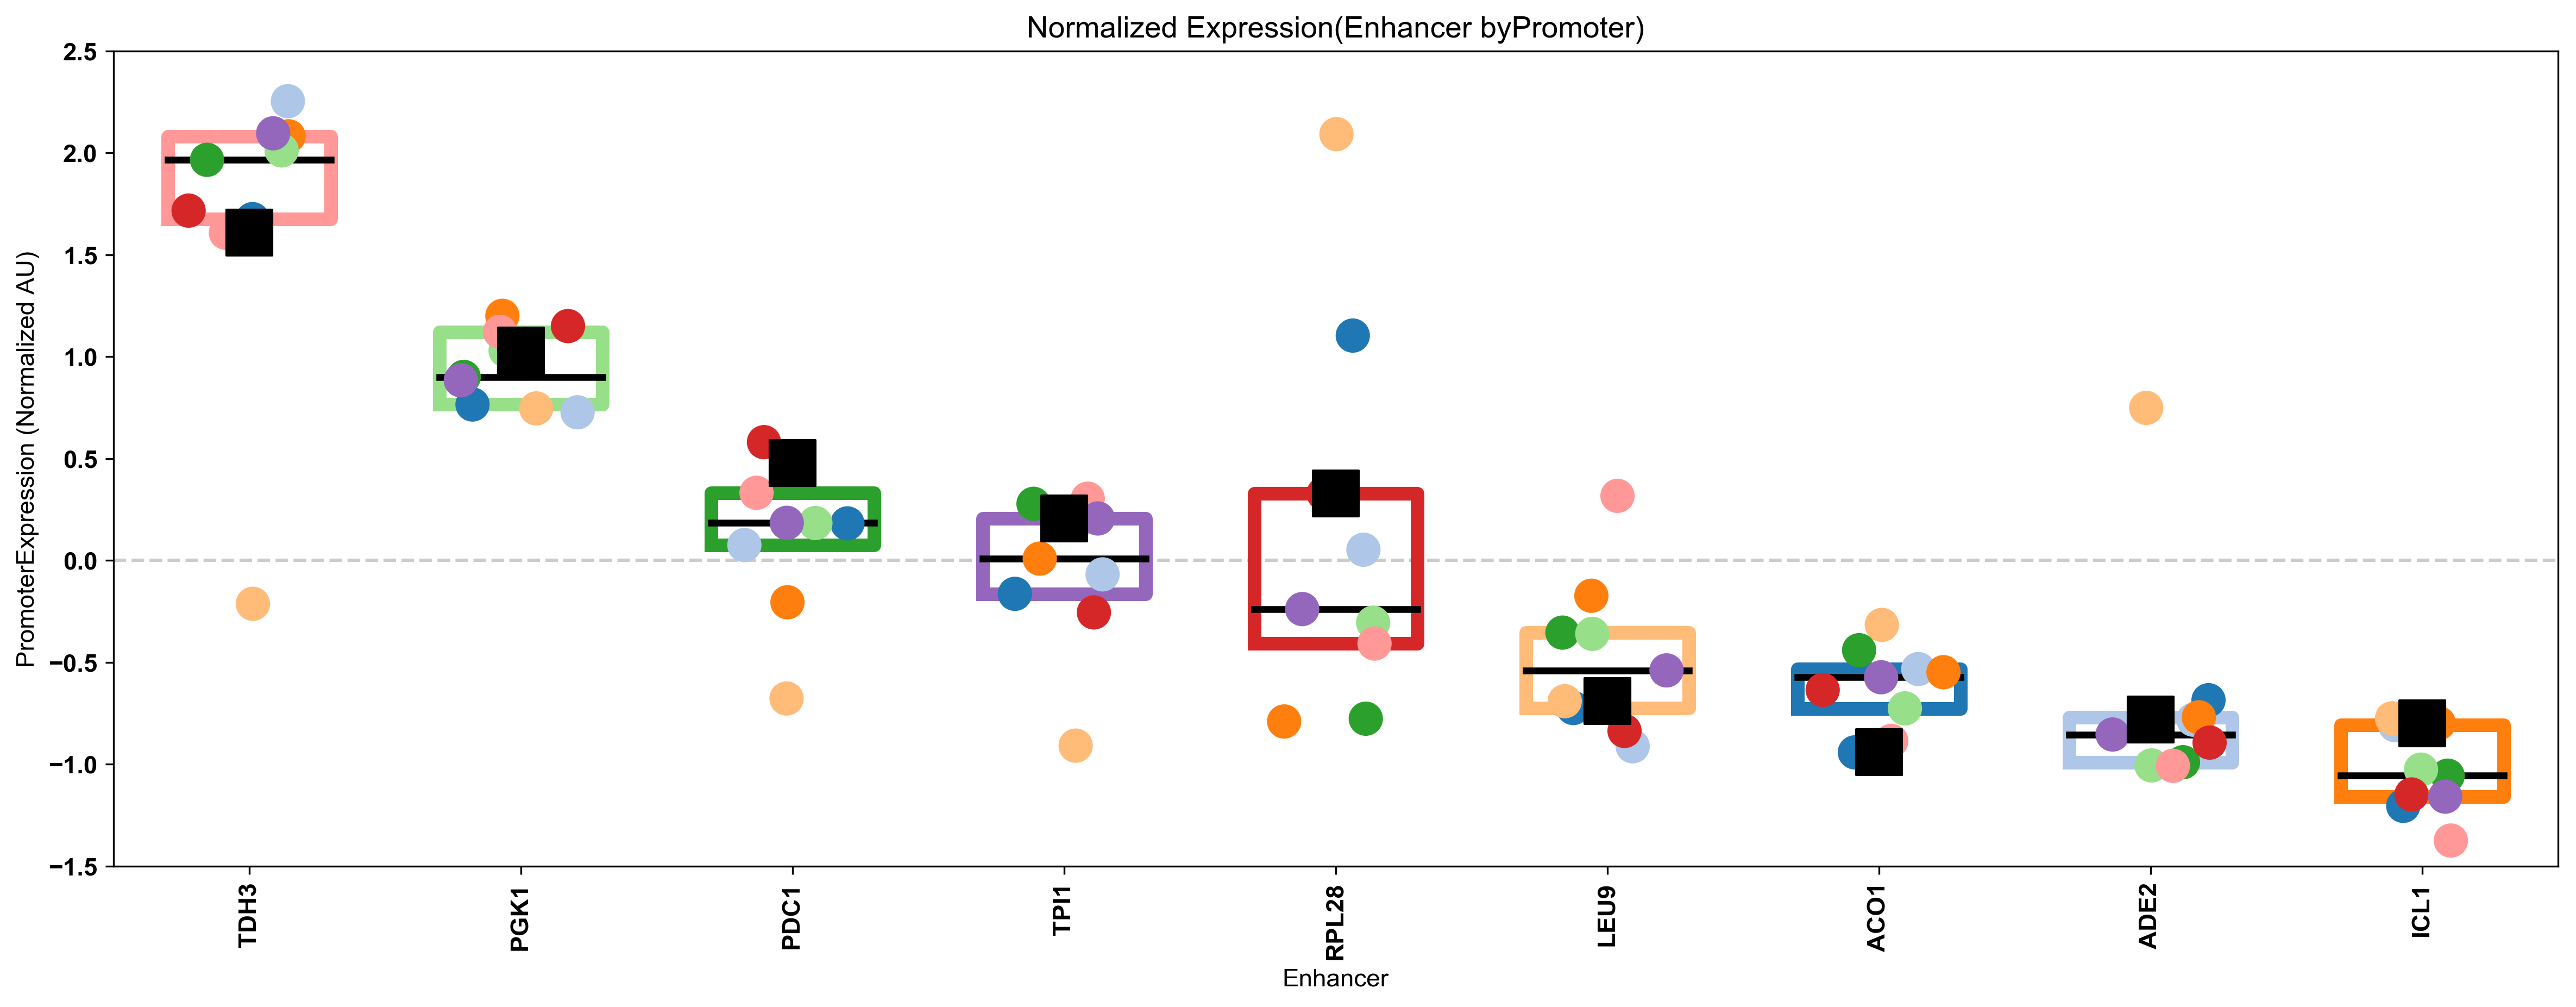

In [34]:
def ZDist9x9 (df,yaxis = __ENHANCER__):
    xaxis    = __PROMOTER__ if yaxis == __ENHANCER__ else __ENHANCER__
    mat      =  df.values
    labels   =  df.index.values
    labels_map     = {label:i for i,label in enumerate(labels)}
    TBP            = scipy.array([labels_map[gene] for gene in __TBP__ if gene in labels_map])
    vmax           = max(df.values.flatten())

    ##GETTING THE SORT ORDER
    means          =  scipy.nanmedian(mat,axis=1)
    order          =  scipy.argsort  (-means)
    ###############################################
    ##Get opposite Sort order for color############
    #omeans         = scipy.nanmedian(reverse.values,axis=0)###
    #oorder         = scipy.argsort  (omeans)#######
    cmap           = plt.get_cmap('tab20')
    colors         = cmap(scipy.arange(len(labels)))
    color_map      = {label:color for label,color in zip(labels,colors)}
    ################################################
    fig             = plt.figure(figsize=(15,5),dpi=300,)
    main_ax         = fig.add_axes([1,1,1,1])
    
    main_ax.axhline(0,color='black',alpha = 0.2,linestyle='--',zorder=1)

    medianprops= dict(markeredgecolor='black',color='black',linewidth=3)
    boxprops = dict(linewidth=6)
    capprops = dict(linewidth=2)
    bp = main_ax.boxplot(mat[order].T,whis=[100,0] ,zorder=1,positions = range(len(mat.T)),widths=0.6,medianprops=medianprops,showfliers=False,showcaps=False,boxprops=boxprops,capprops=capprops)
    [box.set_color(color) for box,color in zip(bp['boxes'],colors[order])]
    for i,row_name in enumerate(labels[order]):
        y       = mat[order][i]
        density = scipy.nan_to_num(scipy.stats.gaussian_kde(y[~scipy.isnan(y)])(y))
        jitter  = scipy.random.rand(len(y))-0.5
        x       = i + (density/max(density) * jitter)/2
        #print(labels[order][i],labels[4],y[labels_map[row_name]],y[4])
        #main_ax.scatter(x[TBP],y[TBP],s=200,color='yellow',zorder=1)
        main_ax.scatter(x,y,c=colors,s=200,zorder=2)
        main_ax.scatter(i,y[labels_map[row_name]],s=400,color='black',marker='s',zorder=2)
    ticks         = main_ax.xaxis.set_ticks(range(len(order)))
    axis_labels   = main_ax.xaxis.set_ticklabels(labels[order],rotation=90)
    txt=main_ax.set_title('Normalized Expression'+ '({} by{})'.format(xaxis, yaxis))
    txt=main_ax.set_xlabel(xaxis)
    txt=main_ax.set_ylabel(yaxis + 'Expression (Normalized AU)')
    main_ax.set_ylim([-1.5,2.5])
    figure = plt.gcf()
    return(figure)

df       = micdata[micdata.Condition=='Glucose'].groupby([__ENHANCER__,__PROMOTER__,__CONDITION__]).mean().reset_index() ##Grouping Replicates
yaxis    = __PROMOTER__
df       = df.set_index([__ENHANCER__,__PROMOTER__]).MaxNormalized.unstack(yaxis)
forward  = df.transform(lambda x: (x-x.mean())/x.std(),axis=0)
reverse  = df.transform(lambda x: (x-x.mean())/x.std(),axis=1)
figure   = ZDist9x9(forward, yaxis)
# figure.savefig(folder+'Zdist9X9Enhancer.svg', bbox_inches="tight")

# df       = micdata[micdata.Condition=='Glucose'].groupby([__ENHANCER__,__PROMOTER__,__CONDITION__]).mean().reset_index() ##Grouping Replicates
# yaxis    = __ENHANCER__
# df       = df.set_index([__ENHANCER__,__PROMOTER__]).MaxNormalized.unstack(yaxis)
# df       = df.transform(lambda x: (x-x.mean())/x.std(),axis=0)
# figure = ZDist9x9(df, yaxis)
# figure.savefig(folder+'Zdist9X9_Promoter.svg', bbox_inches="tight")


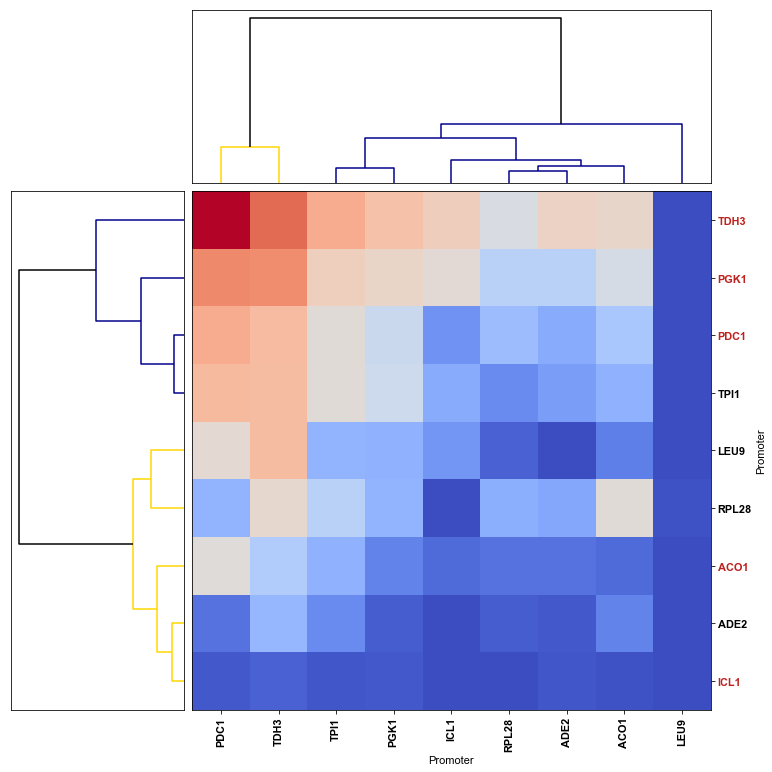

In [35]:
def heatmap (matrix, xlabel='Enhancers', ylabel='Promoters',vmin = 0 , vmax = 1,TBP=True):
    # ##IT would seem rows are observation vectors
    linkageL = scipy.cluster.hierarchy.linkage(matrix  , method='ward', metric='euclidean', optimal_ordering=True)
    orderObs = scipy.cluster.hierarchy.leaves_list(linkageL) #The optimal ordering of leaves in clusters
    linkageT = scipy.cluster.hierarchy.linkage(matrix.T, method='ward', metric='euclidean' , optimal_ordering=True)
    orderFeat= scipy.cluster.hierarchy.leaves_list(linkageT) #The optimal ordering of leaves in clusters
    heatmap   = matrix.values[orderObs][:,orderFeat]
    # mask     = scipy.ones_like(matrix)
    # mask[matrix == 0] = scipy.nan
    #heatmap  = matrix.values[orderObs][:,orderFeat] * mask[orderObs][:,orderFeat]

    ##PLOT HEAT MAP WITH CORRESPONDING DENDOGRAMS
    # Compute and plot first dendrogram.
    fig     = plt.figure(figsize=(12,12))
    y_ax    = fig.add_axes([0.09,0.1,0.2,0.6])
    x_ax    = fig.add_axes([0.3,0.71,0.6,0.2])
    main_ax = fig.add_axes([0.3,0.1,0.6,0.6])

    #cmap = plt.cm.Reds
    cmap = shiftedColorMap(plt.get_cmap('coolwarm'),0.004,0.2,1,name='shiftedcmap')
    #cmp=plt.get_cmap('coolwarm')
    #cmap.set_bad('pink',1.)

    # ##ACTUAL DATA INPUT
    scipy.cluster.hierarchy.set_link_color_palette(['gold','darkblue','black','pink'])
    dendoP  = scipy.cluster.hierarchy.dendrogram(linkageL, labels = matrix.index   , ax = y_ax, orientation='left',above_threshold_color='black' )
    dendoE  = scipy.cluster.hierarchy.dendrogram(linkageT, labels = matrix.columns , ax = x_ax, orientation='top',above_threshold_color='black' )


    image   = main_ax.matshow(heatmap,aspect='auto', origin='lower',cmap = cmap)#,norm=matplotlib.colors.LogNorm(vmin=0.004,vmax=1))

    ##FORMATTING
    setticks=[(ax.set_xticks([]),ax.set_yticks([])) for ax in [x_ax,y_ax]]
    main_ax.yaxis.tick_right()
    main_ax.xaxis.tick_bottom()

    main_ax.xaxis.set_ticks(range(len(matrix.columns )))
    xlabels = main_ax.xaxis.set_ticklabels(matrix.columns[orderFeat],rotation='vertical')
    main_ax.yaxis.set_ticks(range(len(matrix.index )))
    ylabels = main_ax.yaxis.set_ticklabels(matrix.index [orderObs])
    main_ax.yaxis.set_label_position('right')
    main_ax.xaxis.set_label_position('bottom')
    if TBP:
        genes_index = dict(zip(matrix.index[orderObs],scipy.arange(len(matrix.index))))
        mat_index   = list(map(genes_index.get, __TBP__  ))
        [main_ax.get_yticklabels()[i].set_color('#BF211E') for i in mat_index if i is not None]

    # genes_index = dict(zip(matrix.columns[orderFeat],scipy.arange(len(matrix.columns))))
    # mat_index   = list(map(genes_index.get, __5ATAC__ ))
    # [main_ax.get_xticklabels()[i].set_color('#BF211E') for i in mat_index if i is not None]

    # genes_index = dict(zip(matrix.columns[orderFeat],scipy.arange(len(matrix.columns))))
    # mat_index   = list(map(genes_index.get, __3ATAC__ ))
    # [main_ax.get_xticklabels()[i].set_color('#E08E45') for i in mat_index if i is not None]
    label=main_ax.set_xlabel(xlabel)
    label=main_ax.set_ylabel(ylabel)
    figure = plt.gcf()
    return(figure)

df       = micdata[micdata.Condition=='Glucose'].groupby([__ENHANCER__,__PROMOTER__,__CONDITION__]).mean().reset_index() ##Grouping Replicates
yaxis    = __PROMOTER__
df       = df.set_index([__ENHANCER__,__PROMOTER__]).MaxNormalized.unstack(yaxis)
figure   = heatmap(df/max(df.values.flatten()),xlabel='Promoter',ylabel= 'Promoter')
# figure.savefig(folder+'HeatMap9X9.svg', bbox_inches="tight")


<a id='occ'></a>

## Occupancy Plots for TBP ATAC-seq and Chip-seq

1) fastqTBP    mapping TBP  using chip Exo but two tags (check) that fastq file is present and potenitailly there are tags that are in the file that are preventing mapping. 

2) OCC Omar 558/559 strains are duplicates fo one another and each strain was done in duplicate Micrococal nuclease seq

3) ATAC_SEQ from GSE66386

1) Processed data files format and content: *.nucleoatac_signal.bw are BigWig files containing the normalized NucleoATAC signal

2) Processed data files format and content: *.occ.bw are BigWig files containing the nucleosome occupancy

3) Processed data files format and content: *.peaks.final.bed are highly mapable open chromatin regions for which nucleosome 

calling was performed. Analysis was performed on regions around tss that overlapped
with peaks (osmotic.tss_peak_regions.bed).

Processed data files format and content: *.Scores.bw  are BigWig files that contain transposase preference scores used in the sequence bias normalization for nucleosome calling.  These scores represent the log of the relative probability of insertion.

Extracted all bw files into bed files of gene specific regions using

bwtool extract bed Regions.tab sacCer3.Scores.bw sacCer3.Scores.bed;





In [29]:
##Helper Scripts
def bedReader(file_n):
    with open(file_n) as file:
        for line in file:
            line = line.split('\t')
            yield(str(file_n),
                  str(line[0]),
                  int(line[1]),
                  int(line[2]),
                  str(line[3]),
                  str(line[5]),
                  int(line[6]),
                  scipy.array([scipy.float64(score) if not score in ("NA") else scipy.nan for score in line[7].strip().split(',')]))

bed_names = [os.path.basename(x) for x in glob.glob(r'C:\Users\Robert\Desktop\RO\*.bed')]
bed_names

['cerevisiae_lin_all.nucleoatac_signal.bed',
 'cerevisiae_lin_all.occ.bed',
 'fastqH2A.bed',
 'fastqH3.bed',
 'fastqTBP.bed',
 'GSM880648_combine.bed',
 'Normalized_Occ_558J_1_200U_120_180.bed',
 'Normalized_Occ_558J_2_200U_120_180.bed',
 'Normalized_Occ_559J_1_200U_120_180.bed',
 'Normalized_Occ_559J_2_200U_120_180.bed']

## Legend
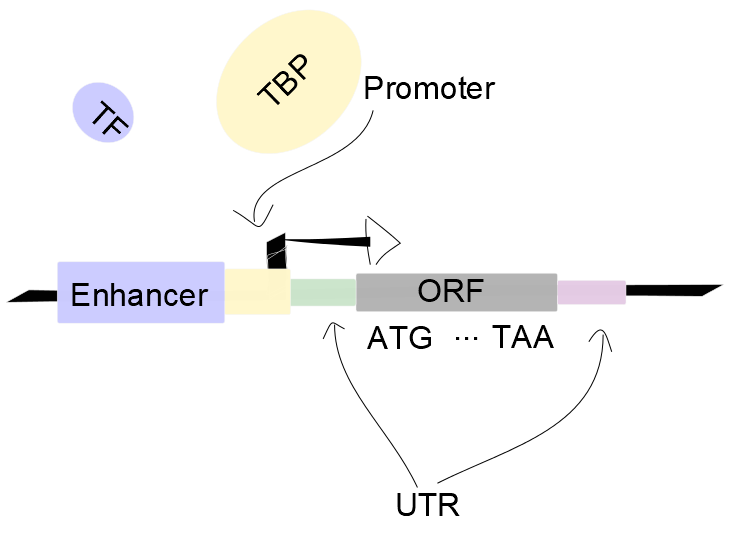

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\pyplot.py:522: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


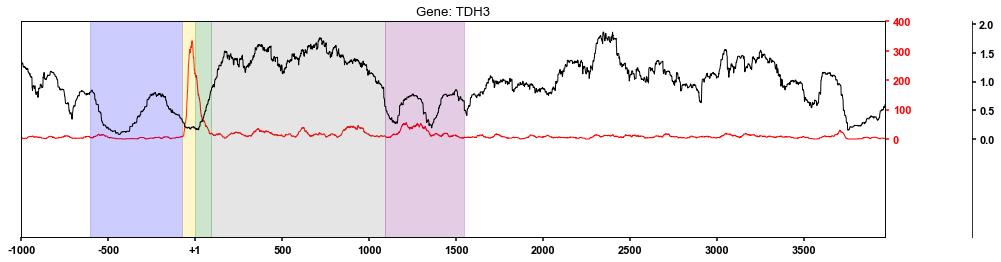

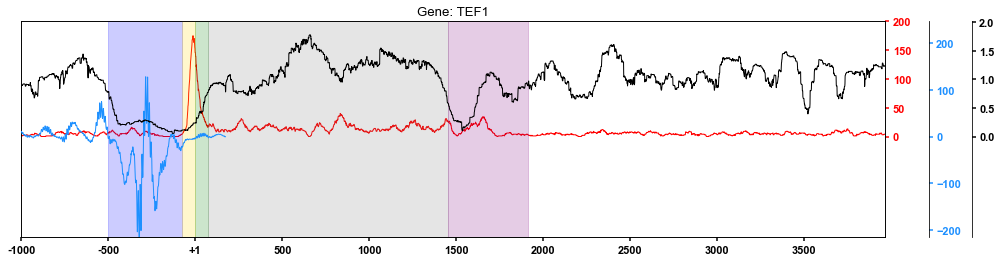

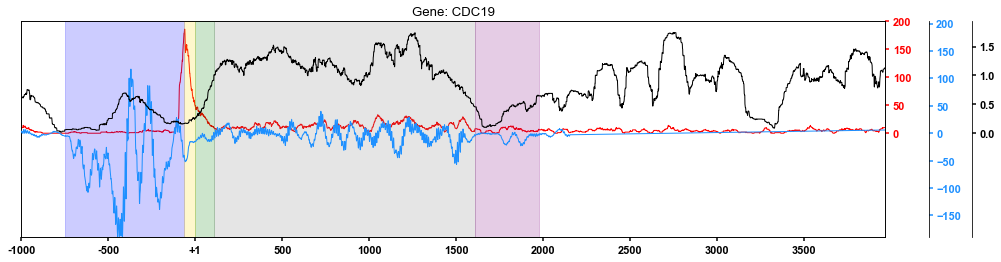

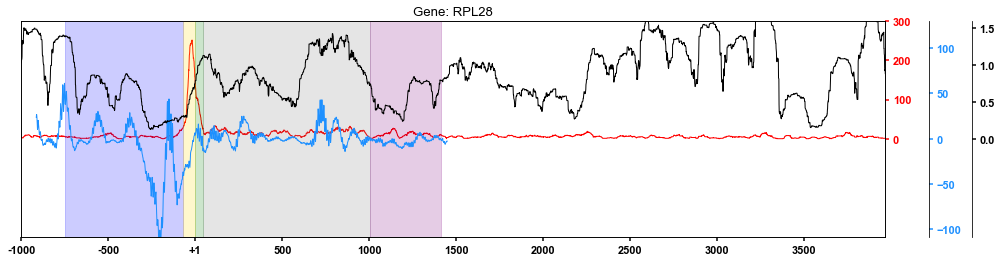

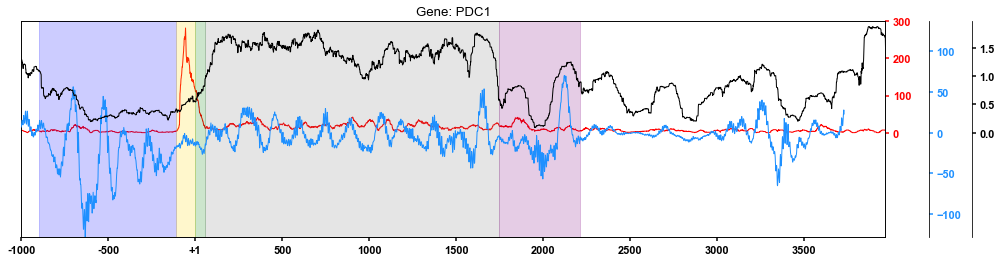

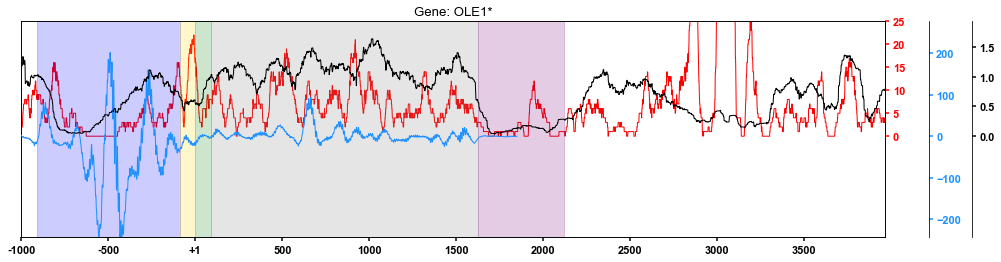

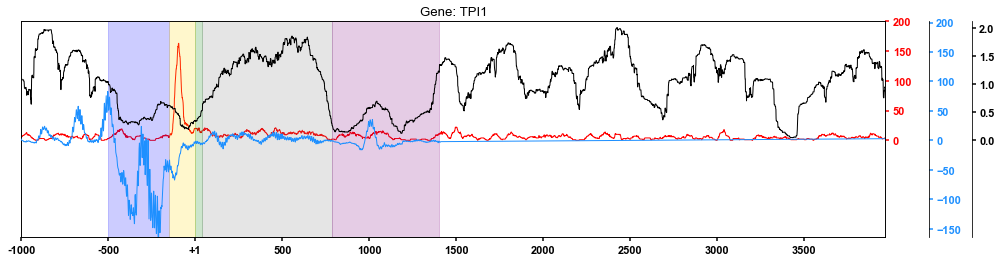

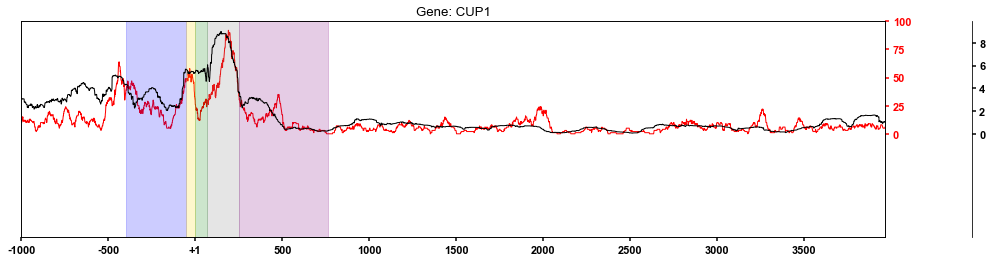

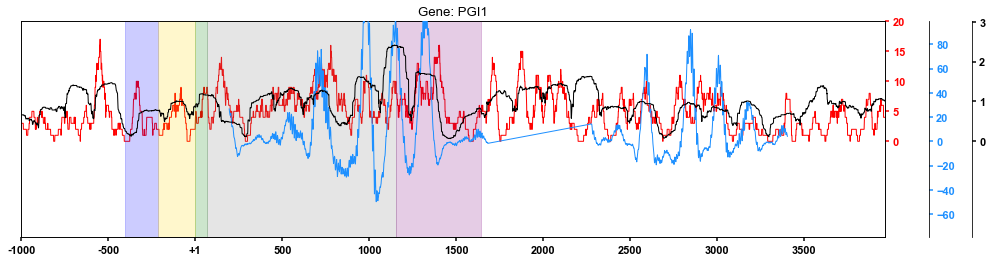

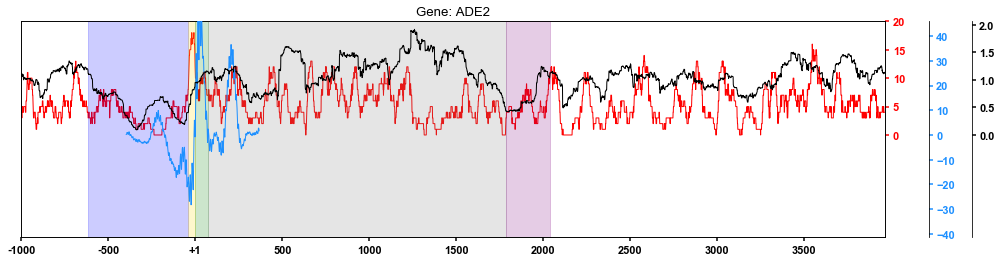

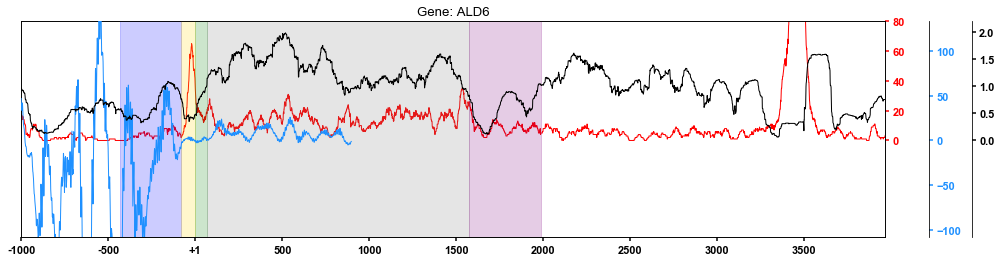

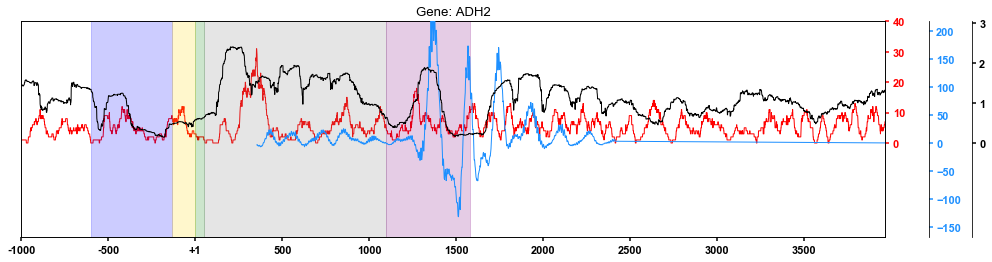

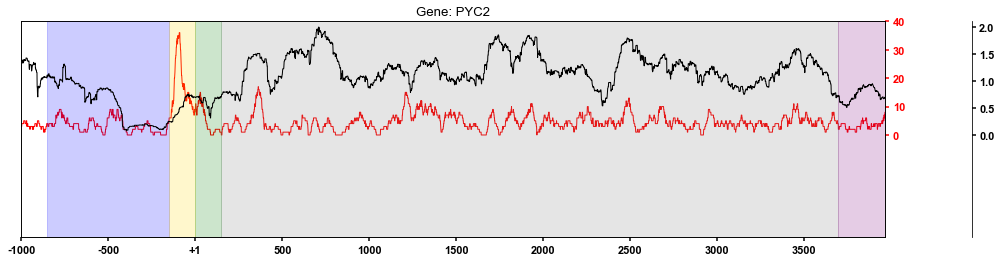

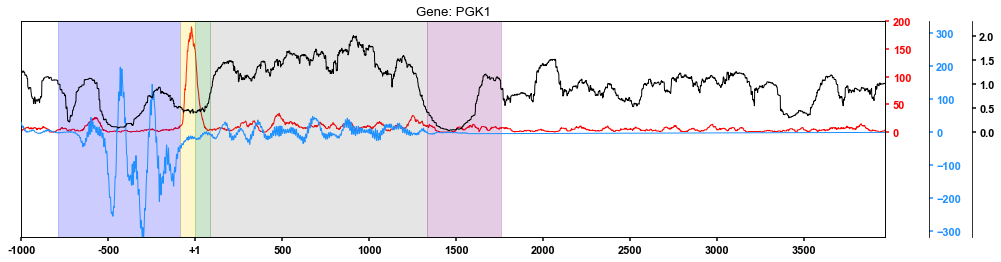

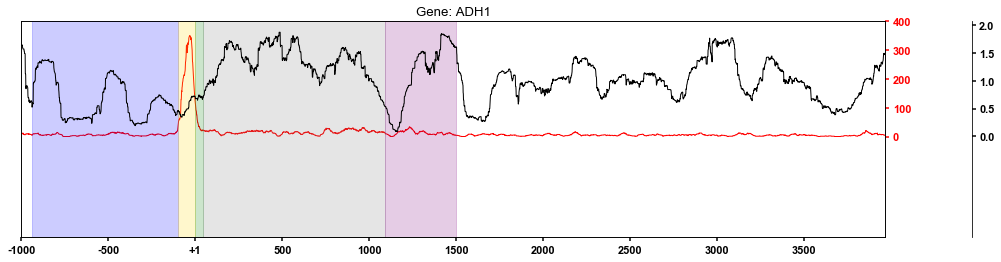

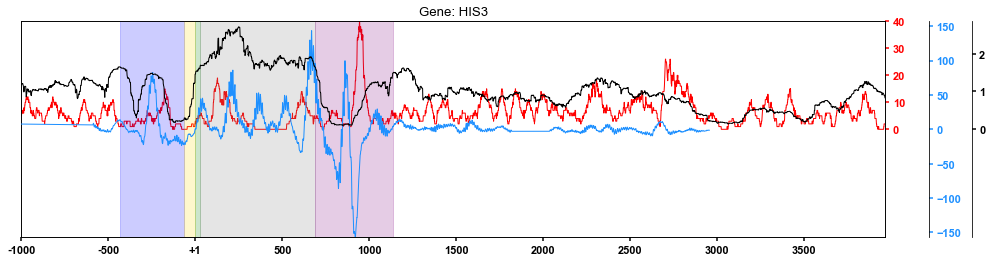

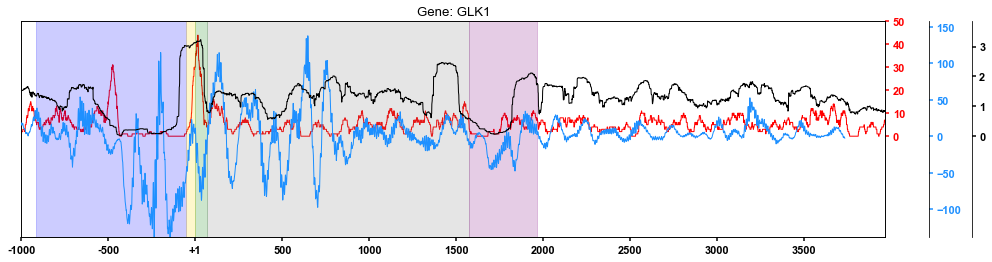

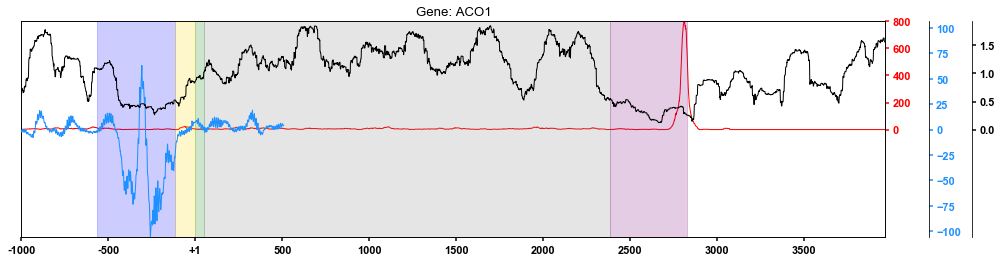

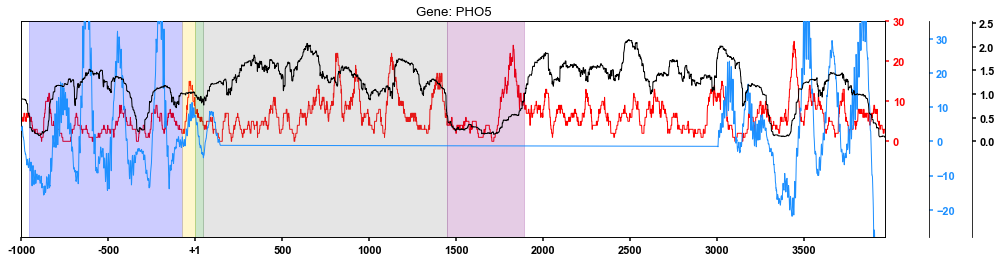

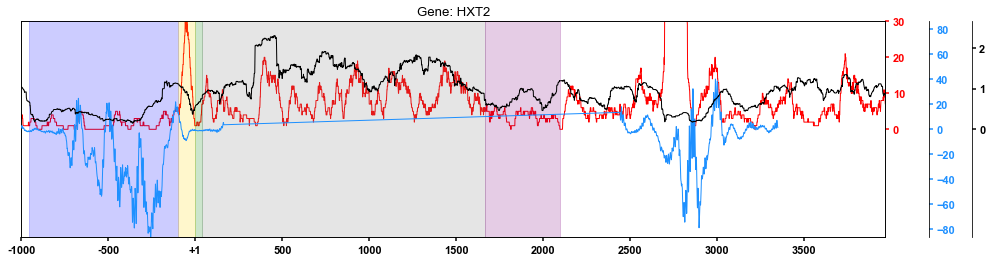

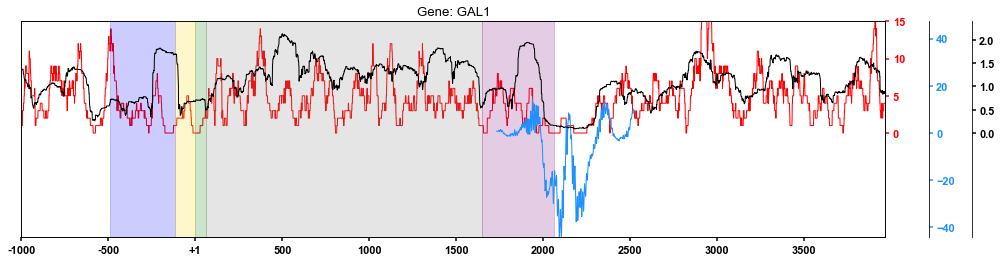

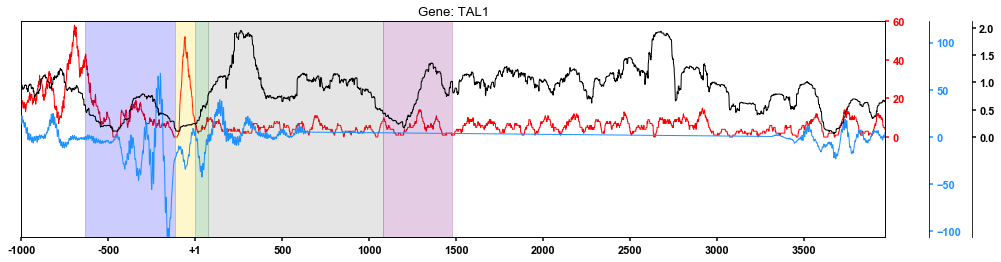

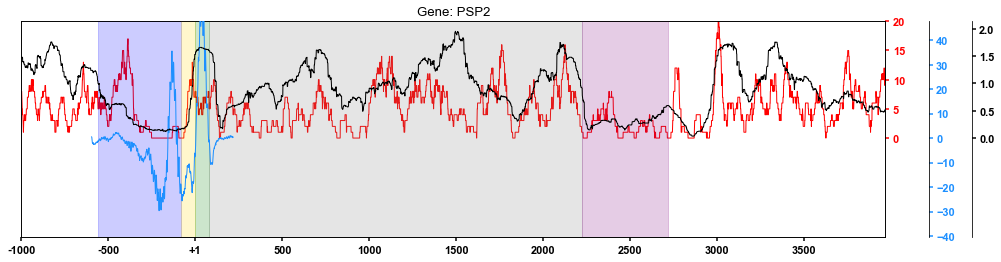

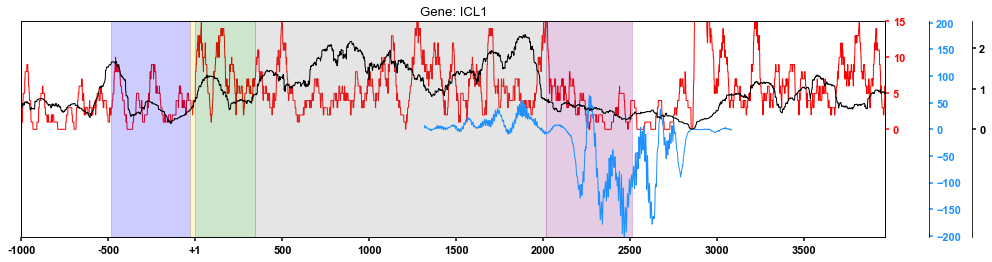

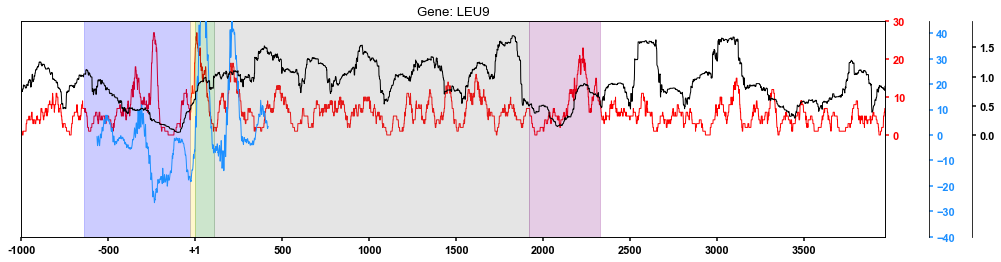

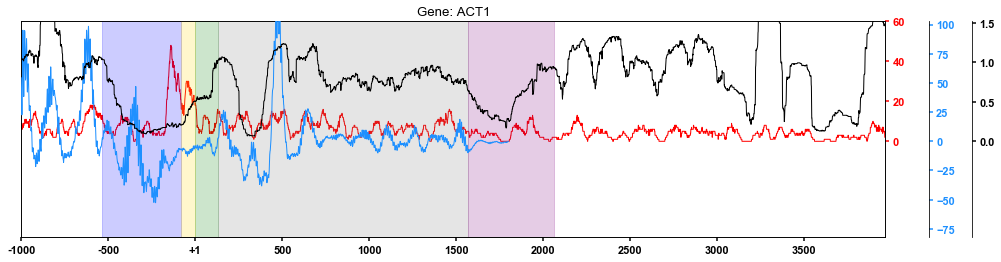

In [149]:
def make_patch_spines_invisible(ax):
    ##https://matplotlib.org/gallery/ticks_and_spines/multiple_yaxis_with_spines.html
    ax.set_frame_on(True)
    ax.patch.set_visible(False)
    for sp in ax.spines.values():
        sp.set_visible(False)

def align_yaxis(ax1, v1, ax2, v2):
    """adjust ax2 ylimit so that v2 in ax2 is aligned to v1 in ax1"""
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

bed_names = [os.path.basename(x) for x in glob.glob(r'C:\Users\Robert\Desktop\RO\*.bed')]
raw          = pandas.DataFrame( row for file in (bedReader(bedfile) for bedfile in bed_names)  for row in file)
raw.columns  = ['File','Chrom','Start','Stop','Gene','Strand','Length','BW']
raw['Data']  = raw.BW#[x if strand == '+' else x[::-1] for x, strand in zip(raw.BW, raw.Strand)]
anno         = pandas.read_csv(r'C:\Users\Robert\Desktop\RO\annotations.txt',sep='\t')
raw          = raw.merge(anno,on='Gene')
df        =raw[raw.File.isin(['Normalized_Occ_558J_1_200U_120_180.bed',
                          'Normalized_Occ_558J_2_200U_120_180.bed',
                          'Normalized_Occ_559J_1_200U_120_180.bed',
                          'Normalized_Occ_559J_2_200U_120_180.bed'])]
omar = df.groupby(['Gene','Chrom','Strand']).mean()
omar['BW']   = df.groupby(['Gene','Chrom','Strand']).BW.apply(lambda x: scipy.median(scipy.array([i for i in x]),axis=0))
omar['Data'] = df.groupby(['Gene','Chrom','Strand']).BW.apply(lambda x: scipy.median(scipy.array([i for i in x]),axis=0))
omar['File'] = 'Normalized_Occ_*_.bed'
omar = omar.reset_index()
temp = raw[raw.File.isin(['cerevisiae_lin_all.nucleoatac_signal.bed',
 'cerevisiae_lin_all.occ.bed',
 'fastqH2A.bed',
 'fastqH3.bed',
 'fastqTBP.bed',
 'GSM880648_combine.bed',
 'sacCer3.Scores.bed'])]
raw  = pandas.concat([temp,omar],sort=True)


# max_value = scipy.amax([x for x in df.Data])
max_coord = scipy.amax([x for x in df.End]) - 1500
min_coord = scipy.amin([x for x in df.Enhancer]) - 1500
zero_coord = scipy.amin([x for x in df.Promoter]) - 1500
##RANKING
#enhancers/promoters/5'utr/3'utr/averageexpressionendoginous
#genes=['TDH3', 'RPL28', 'PGI1', 'PDC1', 'PGK1', 'TPI1', 'CDC19', 'TAL1',    'LEU9', 'PYC2', 'ACO1', 'HIS3', 'ALD6', 'OLE1*', 'TEF1', 'HXT2',       'PSP2', 'ADE2', 'ACT1', 'CUP1', 'ICL1', 'ADH2', 'GAL1', 'PHO5',       'GLK1', 'ADH1']
#genes=['HXT2', 'PDC1', 'ADH1', 'ADH2', 'PHO5', 'TPI1', 'TDH3', 'OLE1*',       'TEF1', 'ALD6', 'HIS3', 'PGK1', 'GLK1', 'RPL28', 'GAL1', 'ACT1',       'TAL1', 'ADE2', 'ACO1', 'PGI1', 'CDC19', 'PSP2', 'CUP1', 'PYC2',       'LEU9', 'ICL1']
genes=['TDH3', 'TEF1', 'CDC19', 'RPL28', 'PDC1', 'OLE1*', 'TPI1', 'CUP1',       'PGI1', 'ADE2', 'ALD6', 'ADH2', 'PYC2', 'PGK1', 'ADH1', 'HIS3',       'GLK1', 'ACO1', 'PHO5', 'HXT2', 'GAL1', 'TAL1', 'PSP2', 'ICL1',       'LEU9', 'ACT1']
#genes=['HIS3', 'RPL28', 'PHO5', 'TPI1', 'ACT1', 'ADE2', 'GAL1', 'PDC1',       'CDC19', 'TDH3', 'PYC2', 'LEU9', 'OLE1*', 'PGI1', 'ACO1', 'GLK1',       'PGK1', 'TAL1', 'ICL1', 'PSP2', 'CUP1', 'TEF1', 'ADH1', 'ALD6',       'HXT2', 'ADH2']
#genes= ['TDH3','PDC1','ADH1','TEF1','CDC19','TPI1','RPL28','OLE1*','PGK1','PGI1','ACT1','ACO1','CUP1','HIS3','PYC2','ALD6','ADE2','GLK1','HXT2','ICL1','PSP2','LEU9','PHO5','ADH2','GAL1','TAL1']
#genes = df.Gene.unique()

for gene in genes:
    df        = raw[raw.File.isin(['fastqTBP.bed'])]    
    max_value = scipy.amax([x for x in df.Data])
    enh,pro,pri5,orf,pri3,end=df[df.Gene==gene][['Enhancer','Promoter','Prime5','Orf','Prime3','End']].values[0]-1500
    x     = scipy.arange(-1500-pri5,4500-pri5)
    enh,pro,pri5,orf,pri3,end=[x - pri5 for x in [enh,pro,pri5,orf,pri3,end]]

    newfig          = plt.figure(figsize=(12,3))
    main_ax         = newfig.add_axes([1,1,1,1])
    background      = main_ax.twinx()
    
    #main_ax.fill_between([0,enh],[height],alpha=0.2)
    background.fill_between([enh , pro  ] ,[-2], [2],alpha=0.2,color='blue')
    background.fill_between([pro , pri5 ] ,[-2],[2],alpha=0.2,color='gold')
    background.fill_between([pri5, orf  ] ,[-2],[2],alpha=0.2,color='green')
    background.fill_between([orf , pri3 ] ,[-2],[2],alpha=0.2,color='grey')
    background.fill_between([pri3, end  ] ,[-2],[2],alpha=0.2,color='purple')
    background.set_ylim([-1,1])
    background.get_yaxis().set_visible(False)
    ax2 = main_ax.twinx()
    ax3 = main_ax.twinx()
    main_ax.yaxis.tick_right()

    ax2.spines["right"].set_position(("axes",1.05))
    make_patch_spines_invisible(ax2)
    ax2.spines["right"].set_visible(True)
    ax3.spines["right"].set_position(("axes", 1.10))
    make_patch_spines_invisible(ax3)
    ax3.spines["right"].set_visible(True)
    ax2.set_ylim([0,1])
    
    tkw = dict(size=4, width=1.5)
    main_ax.tick_params(axis='y', colors= 'red', **tkw)
    ax2.tick_params(axis='y'    , colors= 'dodgerblue', **tkw)
    ax3.tick_params(axis='y'    , colors= 'black', **tkw)
    main_ax.tick_params(axis='x', **tkw)
    

    
    
    df = raw[raw.File.isin(['fastqTBP.bed'])]    
    max_value = scipy.amax([x for x in df.Data])
    mat   = scipy.array(list(df[df.Gene==gene].Data.values))
    y     = scipy.nan_to_num(mat[0])
    height = max(y[enh+1500:end+1500]) or 1
    lowest = min(0,min(y[enh+1500:end+1500]))
    #y=(y-lowest)/(height-lowest)
    main_ax.plot(x,y,lw=1,color='red')
    main_ax.set_ylim([-height,height])


  
    df = raw[raw.File.isin(['cerevisiae_lin_all.nucleoatac_signal.bed'])]    
    max_value = scipy.amax([x for x in df.Data])
    mat   = scipy.array(list(df[df.Gene==gene].Data.values))
    y     = scipy.nan_to_num(mat[0])
    mask  = ~scipy.isnan(mat[0])
    height = max(scipy.absolute(y[enh+1500:end+1500])) or 1
    lowest = min(0,min(y[enh+1500:end+1500]))
    #y=y/(height)
    if any(mask[enh+1500:end+1500]):
        ax2.plot(x[mask],y[mask],lw=1,color='dodgerblue')
        ax2.set_ylim([lowest,height])
    else:
        ax2.get_yaxis().set_visible(False)
        ax2.spines["right"].set_visible(False)

    
    df = raw[raw.File.isin(['Normalized_Occ_*_.bed'])]    
    max_value = scipy.amax([x for x in df.Data])
    mat   = scipy.array(list(df[df.Gene==gene].Data.values))
    y     = scipy.nan_to_num(mat[0])
    height = max(y[enh+1500:end+1500]) or 1
    lowest = min(0,min(y[enh+1500:end+1500]))
    #y=(y-lowest)/(height-lowest)
    ax3.plot(x,y,lw=1,color='black')
    ax3.set_ylim([-height,height])
    
    main_ax.set_title("Gene: {}".format(gene))
    #x=main_ax.set_ylim([-1, 1])
    x=main_ax.set_xlim([min_coord,max_coord])
    x=main_ax.set_xticks(scipy.arange(-1000,max_coord,500))
    x=main_ax.set_xticklabels(scipy.arange(-1000,max_coord,500))
#     x=main_ax.set_xticklabels(scipy.arange(-1500-pro,4500-pro,500))
    labels = [item.get_text() for item in main_ax.get_xticklabels()]
    labels[2] = '+1'
    vat =  main_ax.set_xticklabels(labels)
    
    
    ticks = [tick for tick in main_ax.get_yticks() if tick >=0]
    main_ax.set_yticks(ticks)
    ticks = [tick for tick in ax3.get_yticks() if tick >=0]
    ax3.set_yticks(ticks)
    align_yaxis(main_ax,0,background,0)
    align_yaxis(main_ax,0,ax2,0)
    align_yaxis(main_ax,0,ax3,0)
    figure = plt.gcf()
    figure.savefig(folder+'ChromCoupled_{}.svg'.format(gene.replace('*','')), bbox_inches="tight")


#for file in ,'fastqTBP.bed', 'Normalized_Occ_*_.bed':
#

# Computational References

Andy Pohl, Miguel Beato, bwtool: a tool for bigWig files, Bioinformatics, Volume 30, Issue 11, 1 June 2014, Pages 1618–1619, https://doi.org/10.1093/bioinformatics/btu056

J. D. Hunter, "Matplotlib: A 2D Graphics Environment", Computing in Science & Engineering, vol. 9, no. 3, pp. 90-95, 2007.

Jones E, Oliphant E, Peterson P, et al. SciPy: Open Source Scientific Tools for Python, 2001-, http://www.scipy.org/ [Online; accessed 2019-08-02].

Scikit-learn: Machine Learning in Python, Pedregosa et al., JMLR 12, pp. 2825-2830, 2011.

https://cran.r-project.org/web/packages/venn/venn.pdf 

### For a full list of citations see publication

## Acknowledgements
Occasionally code snippets from others were used (included within above text). Thank you for your contributions.  


